In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, activations
from tensorflow.keras.layers import Conv2D, TimeDistributed, BatchNormalization, MaxPooling2D, Flatten, Bidirectional, Dense,Dropout,Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
x_data = np.load('face_x_data.npy') # x_save.npy
y_data = np.load('face_y_data.npy') # y_data.npy
y_data = keras.utils.to_categorical(y_data,11)
print(x_data.shape, y_data.shape)

(3000, 27, 64, 64, 3) (3000, 11)


In [4]:
# Train과 Test 분리
X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size = 0.2, shuffle = True, stratify=y_data)
print("x_train: {}, X_test: {}".format(X_train.shape, X_test.shape))
print("Y_train: {}, Y_test: {}".format(Y_train.shape, Y_test.shape))

x_train: (2400, 27, 64, 64, 3), X_test: (600, 27, 64, 64, 3)
Y_train: (2400, 11), Y_test: (600, 11)


In [5]:
class VGG_LSTM_fine(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super(VGG_LSTM_fine, self).__init__()
        self.vgg = VGG16(weights='imagenet', include_top=False,
                         input_shape=(input_shape[2], input_shape[3], input_shape[4]))
        self.vgg.trainable = False

        set_trainable = False
        for layer in self.vgg.layers:
            if layer.name == 'block5_conv1' or layer.name == 'block5_conv2' or layer.name == 'block5_conv3' or layer.name == 'block5_pool':
                set_trainable = True
            if set_trainable:
                layer.trainable = True
            else:
                layer.trainable = False
        self.vggDistributed = TimeDistributed(self.vgg)        
        self.bilstm = layers.Bidirectional(layers.LSTM(256), merge_mode='concat')
        self.dense = layers.Dense(num_classes, activation='softmax')
#         self.max_pool = layers.MaxPooling2D(pool_size=(2, 2))
        self.dropout = layers.Dropout(0.2)
        self.flat= TimeDistributed(Flatten())
        
    def call(self, x):
        x = self.vggDistributed(x)
        x = self.flat(x)
        x = self.dropout(x)
        x = self.bilstm(x)
        x = self.dense(x)
        return x

In [6]:
def get_model_vgg_fine():
    return VGG_LSTM_fine(input_shape = (32, 27, 64, 64, 3), num_classes = 11)

In [7]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [8]:
model = get_model_vgg_fine()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
es = EarlyStopping(monitor = 'val_loss', patience = 10)
history = model.fit(X_train, Y_train, batch_size=32, epochs=70, verbose = 1, validation_split = 0.2, callbacks = [es])

/Users/heegeepark/venv/myvenv/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Epoch 1/70
60/60 [==============================] - 2572s 43s/step - loss: 2.4908 - accuracy: 0.0910 - val_loss: 2.3141 - val_accuracy: 0.1375
Epoch 2/70
60/60 [==============================] - 2319s 39s/step - loss: 2.2853 - accuracy: 0.1432 - val_loss: 2.3304 - val_accuracy: 0.1083
Epoch 3/70
60/60 [==============================] - 2311s 39s/step - loss: 2.2597 - accuracy: 0.1538 - val_loss: 2.3232 - val_accuracy: 0.1333
Epoch 4/70
60/60 [==============================] - 2309s 39s/step - loss: 2.1841 - accuracy: 0.2057 - val_loss: 2.2636 - val_accuracy: 0.1500
Epoch 5/70
60/60 [==============================] - 2289s 38s/step - loss: 2.0992 - accuracy: 0.2580 - val_loss: 2.2875 - val_accuracy: 0.1729
Epoch 6/70
60/60 [==============================] - 2291s 38s/step - loss: 2.0167 - accuracy: 0.2884 - val_loss: 2.2242 - val_accuracy: 0.1854
Epoch 7/70
60/60 [==============================] - 2320s 39s/step - loss: 1.9133 - accuracy: 0.3572 - val_loss: 2.1387 - val_accuracy: 0.2354

In [9]:
history.history

{'loss': [2.3873140811920166,
  2.2859959602355957,
  2.249497175216675,
  2.179868459701538,
  2.1155431270599365,
  2.0156776905059814,
  1.9179743528366089,
  1.7968981266021729,
  1.6956737041473389,
  1.5919432640075684,
  1.4402351379394531,
  1.3470484018325806,
  1.1860451698303223,
  1.0693726539611816,
  0.9805891513824463,
  0.8722113966941833,
  0.7341124415397644,
  0.6797593235969543,
  0.5918375253677368,
  0.513901948928833,
  0.4720413088798523,
  0.39179012179374695,
  0.36409318447113037,
  0.30956652760505676,
  0.2603524923324585,
  0.25247302651405334,
  0.21921879053115845,
  0.18883702158927917,
  0.16454392671585083,
  0.17975889146327972,
  0.16330090165138245,
  0.10975204408168793,
  0.10438572615385056,
  0.09572206437587738,
  0.09490050375461578],
 'accuracy': [0.10208333283662796,
  0.1484375,
  0.16770833730697632,
  0.21145834028720856,
  0.24843749403953552,
  0.3036458194255829,
  0.3411458432674408,
  0.3958333432674408,
  0.4307291805744171,
  0.45

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


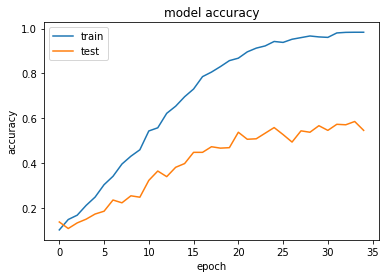

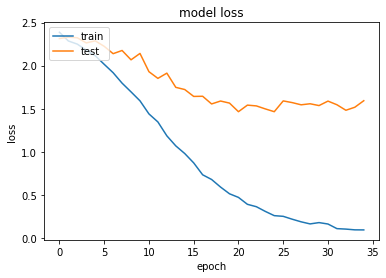

In [10]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose = 1)

/Users/heegeepark/venv/myvenv/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


19/19 [==============================] - 243s 13s/step - loss: 1.6948 - accuracy: 0.5533


In [70]:
from tensorflow.keras.models import load_model

model.save('model_fine_vgg_lip32')

INFO:tensorflow:Assets written to: model_fine_vgg_lip32/assets


INFO:tensorflow:Assets written to: model_fine_vgg_lip32/assets


In [71]:
# 모델 잘 저장되었는지 확인
new_model = tf.keras.models.load_model('model_fine_vgg_lip32')

# Check its architecture
new_model.summary()


Two checkpoint references resolved to different objects (<tensorflow.python.keras.engine.functional.Functional object at 0x179f6e970> and <tensorflow.python.keras.engine.functional.Functional object at 0x1790c1f70>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.engine.functional.Functional object at 0x179f6e970> and <tensorflow.python.keras.engine.functional.Functional object at 0x1790c1f70>).


AssertionError: Some Python objects were not bound to checkpointed values, likely due to changes in the Python program: [<tf.Variable 'block5_conv2/bias:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'block4_conv2/kernel:0' shape=(3, 3, 512, 512) dtype=float32, numpy=
array([[[[ 1.19805969e-02,  1.01811998e-03,  1.17284581e-02, ...,
          -1.21238474e-02, -7.53246993e-03, -2.39460822e-02],
         [-3.86196375e-03,  2.75753811e-03,  1.32147074e-02, ...,
          -2.00085994e-02, -1.39567070e-02, -1.98617168e-02],
         [-1.45046674e-02, -2.11707130e-02, -2.09920108e-03, ...,
          -1.33814635e-02,  1.12934783e-03, -2.25267820e-02],
         ...,
         [ 1.82487406e-02,  1.67690031e-03,  1.32361241e-02, ...,
           9.79885459e-04,  9.98817757e-03, -1.10993534e-03],
         [ 7.66766071e-03, -2.39041857e-02, -1.19678946e-02, ...,
          -1.89708620e-02,  2.40152441e-02, -1.28609128e-03],
         [-1.33832768e-02, -1.21020628e-02, -4.72780876e-03, ...,
          -2.19158102e-02,  1.98975056e-02,  2.08071992e-02]],

        [[-3.77168506e-03, -9.60697420e-03, -2.45443210e-02, ...,
          -1.24697182e-02, -2.29320861e-02,  1.93537474e-02],
         [-1.64367110e-02, -3.46495025e-03,  9.71938670e-03, ...,
          -1.64951775e-02, -1.08755212e-02, -1.31628942e-02],
         [ 1.66614428e-02,  2.27686092e-02,  1.31832808e-02, ...,
          -1.71058998e-02, -6.77420758e-03, -1.37156537e-02],
         ...,
         [ 1.17568299e-02, -1.78846512e-02, -1.66765973e-02, ...,
           1.29136592e-02,  7.00078905e-03,  9.08393040e-03],
         [-2.21691094e-02, -2.16436591e-02,  9.56713408e-03, ...,
          -2.53617018e-03, -4.31944430e-03,  1.28685422e-02],
         [ 2.03333013e-02,  1.33293532e-02,  1.98157318e-03, ...,
          -8.26913677e-03, -2.05961205e-02,  1.20120309e-02]],

        [[-9.13718529e-03,  1.10541284e-02,  2.54149958e-02, ...,
          -1.91698037e-03,  2.18691379e-02,  4.46615741e-03],
         [ 2.15722099e-02, -6.49698824e-03,  2.53031366e-02, ...,
          -1.26343155e-02,  5.98459691e-03, -1.48474472e-02],
         [-8.67619365e-03,  1.99684873e-02,  2.52529979e-02, ...,
          -1.65971350e-02,  7.23670796e-03,  1.08432844e-02],
         ...,
         [ 1.52113847e-02, -2.20845267e-03, -2.00893022e-02, ...,
           1.40982121e-02, -1.12983342e-02, -2.39501521e-02],
         [ 3.21652368e-03,  1.04857348e-02,  2.99763680e-03, ...,
          -1.98066682e-02, -1.66749544e-02, -9.79535095e-03],
         [ 2.81831063e-03,  1.22435242e-02,  2.39306502e-03, ...,
           2.86551192e-03, -1.52813438e-02, -1.10569149e-02]]],


       [[[-2.17290204e-02,  5.80516458e-03, -4.32686135e-03, ...,
           4.99959104e-03,  1.32407732e-02, -3.15577537e-03],
         [ 2.15598345e-02,  1.71777010e-02, -2.37417594e-03, ...,
           1.06545798e-02,  7.14727119e-03,  8.22880864e-03],
         [-1.08680688e-02, -1.79856829e-02, -1.39073348e-02, ...,
           4.51473892e-03,  8.35396349e-03, -4.53282520e-03],
         ...,
         [-1.04139820e-02,  1.13102272e-02,  1.32442266e-03, ...,
           1.08039156e-02, -1.80842765e-02,  6.17614388e-03],
         [ 2.14324445e-02,  8.16815719e-03,  1.84455365e-02, ...,
           1.13137439e-02, -2.02284716e-02,  1.16104893e-02],
         [-6.72738440e-03, -2.14686580e-02,  1.74858049e-03, ...,
          -3.87546234e-03, -1.74111389e-02,  7.57713988e-03]],

        [[-1.16769811e-02,  2.49838307e-02,  1.99460201e-02, ...,
          -8.56402144e-03, -5.91259450e-03,  2.54938751e-02],
         [ 2.20868811e-02, -1.05481930e-02, -1.64373182e-02, ...,
           2.46147588e-02, -6.28647394e-03, -7.85623305e-03],
         [-1.07932985e-02,  2.06179358e-02,  1.30991451e-02, ...,
          -1.30201662e-02,  4.32278402e-03, -1.60999224e-02],
         ...,
         [-1.75198503e-02,  1.48662739e-02,  1.40714347e-02, ...,
          -1.78582128e-02,  2.29077823e-02,  2.06133910e-03],
         [ 9.99623165e-03,  1.00350901e-02, -8.18114541e-03, ...,
           2.00321414e-02, -3.76740843e-03,  1.91103965e-02],
         [-1.77775528e-02,  2.50763185e-02, -5.21716289e-03, ...,
          -7.26756267e-03, -5.37938811e-03, -1.06786815e-02]],

        [[-9.32068378e-03, -8.65638629e-03, -1.28820911e-02, ...,
          -2.54986677e-02, -8.21191072e-03, -2.24133953e-03],
         [ 1.45238787e-02,  1.32801160e-02,  1.69969834e-02, ...,
          -6.13429770e-03,  1.13058276e-02, -4.49699350e-03],
         [-2.03284752e-02,  1.32622942e-03, -1.95179395e-02, ...,
          -2.42263675e-02,  1.63784325e-02, -2.00706907e-03],
         ...,
         [-2.48496272e-02,  1.11420639e-03,  1.43847354e-02, ...,
           1.26740634e-02,  1.34506673e-02,  1.93327293e-02],
         [-1.10243568e-02, -2.12868750e-02,  1.68074295e-02, ...,
          -1.04122171e-02, -1.74356978e-02,  1.62583590e-02],
         [-9.31022689e-03, -1.21632554e-02, -9.41232406e-03, ...,
          -1.07731801e-02,  1.23618841e-02, -1.96648948e-02]]],


       [[[ 3.66894901e-03,  3.69913504e-03,  1.33525357e-02, ...,
           1.92907080e-02,  1.12483762e-02, -1.82811525e-02],
         [ 1.60288922e-02,  1.48628205e-02, -1.94620378e-02, ...,
           2.40078904e-02,  1.75371766e-04, -2.31012106e-02],
         [-3.37987393e-03,  6.60757720e-03, -2.33236849e-02, ...,
           2.44900584e-02, -7.20410794e-03, -2.38104947e-02],
         ...,
         [ 8.95148888e-03,  7.07049295e-03,  7.51088560e-03, ...,
          -1.39148291e-02,  2.36897357e-02,  1.81339644e-02],
         [ 6.20678067e-03, -1.90730505e-02, -2.06780806e-02, ...,
           1.93854384e-02, -2.15624701e-02, -1.92140006e-02],
         [-2.32782923e-02, -4.01593372e-03,  2.22212076e-02, ...,
          -7.98435882e-04, -1.67637132e-03, -1.39766745e-03]],

        [[ 8.50538537e-03,  1.72653161e-02,  2.22342275e-02, ...,
           1.50796063e-02,  1.45411193e-02, -1.97073389e-02],
         [-7.18485937e-03, -5.55678457e-03, -2.27816571e-02, ...,
           3.94632667e-03, -1.54606439e-03, -1.30211571e-02],
         [ 1.08228587e-02, -9.68664140e-03,  1.55242272e-02, ...,
           2.50820965e-02,  1.81968436e-02,  1.68014579e-02],
         ...,
         [ 1.50756091e-02,  6.75478205e-03, -2.12975964e-03, ...,
          -1.12231430e-02, -9.38938372e-03,  2.21228451e-02],
         [-1.38745205e-02, -5.73013723e-03, -4.20142710e-03, ...,
           1.52869523e-02, -1.98012963e-02,  1.32425390e-02],
         [ 1.37662850e-02,  1.47391111e-05, -1.05906427e-02, ...,
          -1.13941226e-02,  5.17299399e-04, -1.89553052e-02]],

        [[ 2.43403316e-02, -1.43928491e-02,  1.20073073e-02, ...,
          -1.12866964e-02,  4.99206595e-03, -2.24265885e-02],
         [-1.14740990e-03, -1.64844394e-02,  1.50827207e-02, ...,
          -2.87131593e-03,  2.12154575e-02,  6.32986426e-03],
         [ 3.31606530e-03, -1.81579590e-03, -2.56878324e-03, ...,
           2.41645537e-02, -1.41004659e-03,  1.32160857e-02],
         ...,
         [-4.82975505e-03, -1.00530554e-02, -7.80668110e-04, ...,
          -9.50740092e-03, -4.81024571e-03,  5.35148941e-03],
         [ 2.18758620e-02, -2.52337754e-03, -1.90017186e-03, ...,
           2.11907104e-02,  1.89543441e-02, -6.31549023e-03],
         [ 1.75900161e-02,  1.68284327e-02,  1.79264881e-03, ...,
           9.82005522e-03, -2.29009036e-02, -2.12378670e-02]]]],
      dtype=float32)>, <tf.Variable 'block4_conv1/kernel:0' shape=(3, 3, 256, 512) dtype=float32, numpy=
array([[[[ 0.01154722, -0.02342631, -0.02355535, ..., -0.02714155,
           0.00469432, -0.00119318],
         [ 0.02867495,  0.02359416,  0.02205964, ...,  0.00564293,
          -0.02680866,  0.00082604],
         [-0.0236211 ,  0.02410824,  0.01528536, ...,  0.02465501,
          -0.01975268, -0.02307332],
         ...,
         [ 0.00340162,  0.02351206, -0.02619195, ..., -0.02854186,
          -0.01138887, -0.01304983],
         [-0.00305641,  0.01551646, -0.01060316, ..., -0.00455413,
           0.00214931, -0.02124486],
         [ 0.02396834,  0.01789671, -0.00674145, ..., -0.01885907,
          -0.01427739, -0.01692845]],

        [[ 0.01712619,  0.00648452, -0.01117333, ..., -0.01902249,
          -0.02115346, -0.00361267],
         [-0.01382625,  0.01642225, -0.00945107, ...,  0.00275931,
           0.01807628, -0.02277103],
         [ 0.0245344 , -0.02225906, -0.01089856, ...,  0.00596856,
          -0.02527028, -0.02603992],
         ...,
         [ 0.00588478,  0.00439292,  0.01413843, ...,  0.0094491 ,
           0.00635453, -0.00757808],
         [-0.01538113, -0.02856149,  0.01721045, ..., -0.00517339,
          -0.02096478, -0.00941724],
         [ 0.01021203,  0.01892785,  0.01170715, ..., -0.00959029,
           0.02087013, -0.02459532]],

        [[ 0.00764794,  0.00207712,  0.02833233, ..., -0.0138199 ,
           0.00295241, -0.00961241],
         [ 0.0138499 , -0.01455188,  0.02797061, ..., -0.02902328,
           0.00900549,  0.00175058],
         [-0.00954269,  0.02908419,  0.00361928, ..., -0.0098482 ,
           0.00465679,  0.01195446],
         ...,
         [-0.00707693,  0.00646096, -0.01969628, ..., -0.00753162,
          -0.00618065, -0.0234394 ],
         [ 0.00451052,  0.00691824,  0.00956599, ..., -0.0102384 ,
           0.01196369, -0.02406929],
         [ 0.00931384, -0.00610886,  0.00432724, ...,  0.02757606,
           0.02257677, -0.02255299]]],


       [[[ 0.01642349, -0.01519686,  0.00974085, ...,  0.02421614,
           0.00359397,  0.01562754],
         [ 0.00866076, -0.00768756,  0.0129823 , ..., -0.01194284,
           0.0260392 , -0.0286672 ],
         [-0.0194324 ,  0.02459143, -0.0053299 , ..., -0.00183122,
          -0.01518114,  0.00956016],
         ...,
         [ 0.02411397,  0.02298051, -0.01841928, ..., -0.02866386,
           0.02362596, -0.02847743],
         [ 0.0280507 ,  0.01079453, -0.00806509, ..., -0.00038734,
          -0.02382989,  0.00341278],
         [-0.02524798,  0.0104247 ,  0.0092517 , ...,  0.01173643,
          -0.00468169, -0.02021546]],

        [[ 0.02210656,  0.02331444, -0.00211958, ..., -0.02775352,
          -0.00620016, -0.00977874],
         [ 0.02586875,  0.02543624,  0.01343331, ...,  0.02403783,
          -0.02697533,  0.01439514],
         [-0.00333996, -0.01109653,  0.00117464, ..., -0.02476445,
           0.00815256,  0.01277618],
         ...,
         [ 0.00639019,  0.00198647,  0.02168223, ...,  0.00720666,
           0.00470448, -0.00677145],
         [ 0.0246757 ,  0.01113212,  0.00342565, ...,  0.00539574,
           0.02263313, -0.00122875],
         [-0.0206641 , -0.00103978,  0.02392692, ..., -0.02768618,
          -0.00098665, -0.01038163]],

        [[ 0.02661531,  0.00912216, -0.01444242, ..., -0.02104437,
          -0.01975714, -0.01215777],
         [-0.00332018, -0.01205096, -0.0195723 , ...,  0.01119224,
           0.0183804 ,  0.01627556],
         [-0.00350744,  0.00342345,  0.00018875, ..., -0.01554334,
          -0.00161562,  0.01699839],
         ...,
         [-0.00736703, -0.00206045, -0.01733726, ...,  0.01431471,
           0.02206699, -0.02599266],
         [-0.02511325,  0.00139714, -0.01089517, ..., -0.02304101,
           0.0063435 ,  0.00476457],
         [ 0.01322063,  0.01285558, -0.00421816, ..., -0.02312921,
          -0.00252775,  0.024491  ]]],


       [[[ 0.02637474,  0.01125277,  0.00220471, ..., -0.0069173 ,
          -0.02872758,  0.01950379],
         [ 0.01639985,  0.01698559, -0.01773839, ..., -0.02547086,
           0.02284875,  0.0230653 ],
         [ 0.01185724,  0.00475499, -0.01471901, ..., -0.02839898,
           0.00239235,  0.01768926],
         ...,
         [ 0.01394735,  0.00946066,  0.0109467 , ..., -0.02672929,
          -0.00176358, -0.00104623],
         [-0.00887833,  0.00743776, -0.01153357, ..., -0.00894613,
           0.0110382 ,  0.01740858],
         [-0.00091177,  0.01513791,  0.0087976 , ..., -0.01771113,
           0.00709175, -0.02052911]],

        [[-0.02573866,  0.01847518, -0.0016952 , ...,  0.00782693,
           0.02529457, -0.02740772],
         [-0.00607057,  0.01767928, -0.00523531, ..., -0.02433739,
          -0.02881012,  0.00501834],
         [-0.01359297,  0.00211031, -0.01783643, ...,  0.00514975,
          -0.02375468,  0.00822168],
         ...,
         [-0.02455632,  0.00690663,  0.01297803, ...,  0.02375627,
           0.00241571,  0.02637302],
         [-0.01154651,  0.01184375,  0.01324186, ..., -0.00625336,
           0.02828202,  0.01329882],
         [-0.00809484, -0.02084639,  0.02705344, ...,  0.00077808,
           0.01927856, -0.01790692]],

        [[ 0.02091825,  0.02575662,  0.01792789, ...,  0.01344688,
          -0.02327905, -0.02479929],
         [ 0.02882178,  0.02923856,  0.00921358, ..., -0.02148296,
           0.01524013,  0.00638208],
         [ 0.01459731,  0.00416898, -0.0046366 , ..., -0.0067142 ,
           0.00173677,  0.00273419],
         ...,
         [ 0.00512968,  0.00489385, -0.02255676, ...,  0.0149563 ,
           0.01255848, -0.00878319],
         [-0.02784695, -0.01313077,  0.00244832, ..., -0.01776467,
           0.0108871 ,  0.01425357],
         [-0.01298967, -0.02638844,  0.01470794, ..., -0.02076124,
          -0.00110134, -0.02184218]]]], dtype=float32)>, <tf.Variable 'block1_conv2/bias:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'block3_conv2/bias:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'block3_conv3/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[ 0.03414969,  0.00721527, -0.01730628, ...,  0.00810468,
          -0.01661689, -0.00940434],
         [-0.01913348, -0.02288003, -0.00199835, ...,  0.0331101 ,
          -0.02514531, -0.01453119],
         [-0.00555166, -0.00401915, -0.0063901 , ...,  0.02076292,
           0.03334467, -0.03360368],
         ...,
         [-0.03063621, -0.00531289, -0.01613449, ..., -0.02655742,
           0.01626381, -0.02052154],
         [ 0.01143932,  0.01572006, -0.02905543, ..., -0.01359529,
          -0.00535016,  0.01695971],
         [ 0.0021203 , -0.00131576,  0.03490047, ..., -0.01809011,
           0.0250196 ,  0.02627822]],

        [[ 0.0347169 ,  0.03420889,  0.00798119, ..., -0.01439493,
          -0.0021361 ,  0.03537124],
         [ 0.00286153, -0.02437074, -0.02120125, ..., -0.01347332,
          -0.00183131,  0.02443163],
         [ 0.02652549, -0.00361152, -0.00683354, ..., -0.01540213,
          -0.0348659 , -0.02715402],
         ...,
         [ 0.03273913, -0.02197932,  0.00579905, ..., -0.02510169,
          -0.01931463, -0.01674904],
         [ 0.00922231,  0.03511323,  0.02140449, ..., -0.01029142,
           0.02164672, -0.01082122],
         [-0.0223913 , -0.03420239,  0.02789222, ..., -0.0204146 ,
          -0.01713286, -0.02489444]],

        [[ 0.02270773,  0.02045707, -0.03310961, ...,  0.02621243,
           0.02491246,  0.02342249],
         [ 0.00256133,  0.01236962, -0.00704267, ..., -0.00313795,
           0.01024168,  0.03398485],
         [-0.02113142, -0.02965996,  0.0225049 , ..., -0.01811025,
           0.0305868 , -0.01171477],
         ...,
         [ 0.02437926, -0.02043391, -0.02983076, ..., -0.00420549,
          -0.01270605,  0.00917844],
         [-0.02495066,  0.00738772,  0.00208882, ...,  0.01814815,
           0.00733616,  0.01079429],
         [-0.03289133, -0.00296345,  0.00587348, ..., -0.01753517,
          -0.00416161, -0.02594791]]],


       [[[-0.01787528, -0.03555404,  0.02807649, ..., -0.00618506,
           0.01329788, -0.03293994],
         [-0.00335557, -0.02231134, -0.03356631, ...,  0.00074448,
           0.02101905,  0.02685992],
         [-0.00740987, -0.01950585, -0.02325546, ...,  0.03117269,
          -0.03391208,  0.01427485],
         ...,
         [ 0.03328357,  0.02724534, -0.03491084, ..., -0.0353087 ,
           0.02674025, -0.01128227],
         [ 0.02987444,  0.02481493,  0.00718684, ..., -0.00250139,
          -0.0117118 ,  0.03226426],
         [-0.02259487,  0.01475009, -0.03098982, ...,  0.00760732,
           0.01914703,  0.03185412]],

        [[ 0.02483183,  0.00223168, -0.02805153, ..., -0.01161919,
          -0.03380802, -0.02657771],
         [-0.0274594 , -0.0083674 ,  0.03196237, ..., -0.02646882,
           0.01583407, -0.01491361],
         [ 0.01417145,  0.01227837,  0.03261582, ...,  0.00967837,
          -0.02661202, -0.02234991],
         ...,
         [-0.01142639, -0.03513949,  0.00437751, ..., -0.00920065,
           0.01059807,  0.01932234],
         [-0.01663213, -0.00610531,  0.00489389, ...,  0.01220375,
          -0.01787368,  0.0154255 ],
         [ 0.01597143,  0.00067385,  0.01076344, ..., -0.02576389,
          -0.02637256, -0.00316948]],

        [[-0.02365703,  0.01026033,  0.03214204, ...,  0.01105979,
           0.03455668,  0.03346112],
         [-0.03511976, -0.00879266, -0.00939235, ..., -0.01749448,
           0.03439946, -0.00242191],
         [-0.03572166, -0.03179969, -0.02920803, ..., -0.01539671,
          -0.03477462,  0.00964638],
         ...,
         [ 0.01326028,  0.02631166, -0.00778311, ..., -0.00108333,
           0.03193501,  0.03508531],
         [-0.03364881,  0.01538036, -0.01561161, ...,  0.00872881,
           0.00938788, -0.01334466],
         [-0.00831292,  0.0019403 , -0.0355626 , ..., -0.00442992,
          -0.02473198, -0.00431228]]],


       [[[-0.02111463, -0.0154124 ,  0.01582083, ..., -0.02138551,
          -0.01746997,  0.01876673],
         [ 0.02573273,  0.00588974,  0.0106881 , ..., -0.02887004,
          -0.03186951, -0.0305052 ],
         [ 0.01704831,  0.02618725,  0.0288203 , ...,  0.00905642,
           0.01434764, -0.01659279],
         ...,
         [ 0.02569003, -0.03043029,  0.00376048, ..., -0.02973377,
          -0.00474282,  0.01147204],
         [-0.01111791, -0.0330036 ,  0.02534285, ..., -0.00056438,
          -0.01284699, -0.01492545],
         [ 0.0328972 ,  0.00112513, -0.03401426, ...,  0.03281695,
          -0.01465451, -0.00765107]],

        [[ 0.00216344, -0.0292816 ,  0.03344291, ...,  0.00341715,
           0.01920696, -0.03061788],
         [-0.01083145,  0.02950563, -0.01565334, ..., -0.02681102,
           0.01328775, -0.01908421],
         [-0.03091208, -0.01364709, -0.01166105, ..., -0.01671773,
          -0.026824  ,  0.0023868 ],
         ...,
         [-0.0241084 , -0.02517913, -0.03535739, ..., -0.00072698,
          -0.0348031 , -0.01484417],
         [ 0.02375807, -0.03273325,  0.00271309, ...,  0.00842205,
           0.02828508,  0.01343563],
         [-0.01128703,  0.01640629,  0.00854909, ..., -0.03320793,
          -0.01153436, -0.01874276]],

        [[-0.00422751, -0.01406902, -0.03188375, ...,  0.01773515,
          -0.02737154, -0.01318945],
         [-0.00433275,  0.02929763, -0.00492074, ...,  0.00257243,
           0.02393888, -0.03276199],
         [ 0.02381185, -0.02122677,  0.01519587, ...,  0.0176357 ,
           0.00947708,  0.02936178],
         ...,
         [ 0.02955717, -0.00086691, -0.02775739, ...,  0.01623538,
          -0.01138312, -0.03324296],
         [ 0.02825116, -0.01974225, -0.03520087, ...,  0.01212109,
           0.03528969, -0.00690313],
         [ 0.00668205, -0.00829346, -0.01748316, ...,  0.00365531,
          -0.02019222, -0.0288894 ]]]], dtype=float32)>, <tf.Variable 'block4_conv3/kernel:0' shape=(3, 3, 512, 512) dtype=float32, numpy=
array([[[[ 1.29281357e-03,  1.79136321e-02, -1.80042312e-02, ...,
           2.18424015e-02,  1.57407187e-02,  1.53821148e-02],
         [-3.05584818e-03, -2.53977142e-02,  9.63818654e-03, ...,
           1.19277090e-02,  1.39144324e-02, -5.48462383e-03],
         [-3.30374017e-03,  1.80238150e-02,  9.09732655e-04, ...,
           3.20259482e-04,  3.65769491e-03, -1.67372972e-02],
         ...,
         [ 2.50277668e-02,  2.97185034e-04,  1.80367939e-02, ...,
           2.26184726e-03,  3.55174206e-03,  1.04424395e-02],
         [-2.23082546e-02,  1.82376094e-02, -6.45437464e-03, ...,
           2.52136439e-02,  6.06670976e-04, -2.83212774e-03],
         [ 2.34688595e-02,  1.50640868e-02,  1.34225860e-02, ...,
           7.82343745e-03,  2.44348124e-02, -1.84839480e-02]],

        [[-1.62847601e-02,  5.03181480e-03,  4.28436138e-03, ...,
          -3.24999355e-03, -2.02574041e-02,  2.11885683e-02],
         [ 7.50964507e-03,  4.01251018e-05, -4.11354005e-03, ...,
          -2.37926655e-02, -1.39866928e-02, -9.38291103e-03],
         [-8.60037655e-03, -5.25595061e-03,  7.41518289e-03, ...,
           1.42058283e-02, -1.34615144e-02, -3.00111622e-03],
         ...,
         [ 2.13701427e-02, -1.03192208e-02,  5.39268553e-03, ...,
          -1.59444734e-02, -2.09931694e-02, -6.09069131e-03],
         [ 2.49276757e-02,  5.91422990e-03,  1.82557851e-05, ...,
          -1.46144293e-02, -1.95988845e-02,  2.22061388e-02],
         [ 1.24693960e-02,  2.12659165e-02, -1.41780144e-02, ...,
          -1.00374389e-02,  2.13146806e-02,  1.09132491e-02]],

        [[-2.22925730e-02,  1.29369684e-02, -1.78499147e-02, ...,
           6.16466627e-03, -1.39338523e-02, -2.40924656e-02],
         [-5.71383350e-03,  1.85518339e-02, -9.16641578e-03, ...,
          -1.26213338e-02,  1.34274177e-02,  5.54542989e-04],
         [ 6.27203286e-03, -3.38026322e-03, -2.25467347e-02, ...,
           5.25854714e-03,  1.19205602e-02,  2.54643895e-03],
         ...,
         [-3.14973295e-03, -3.03206965e-03,  5.39711490e-03, ...,
          -2.40359753e-02,  2.45845579e-02, -2.24033743e-02],
         [-5.50398603e-04, -1.04216281e-02,  2.25327238e-02, ...,
           4.29352745e-04,  1.36070363e-02, -1.83346681e-02],
         [ 2.50700898e-02,  4.40474600e-03, -9.39626992e-03, ...,
          -1.63418166e-02, -1.44790197e-02, -1.23475390e-02]]],


       [[[-5.20511717e-03, -2.95640342e-03, -7.01301731e-03, ...,
          -1.40977688e-02,  1.39119998e-02,  1.72039680e-02],
         [ 2.49274634e-02, -1.70543976e-02,  2.52327770e-02, ...,
           1.94787309e-02, -2.44307984e-02, -6.42031431e-03],
         [ 1.29523166e-02, -2.45032832e-03, -1.18540041e-03, ...,
           1.54669471e-02, -1.71612222e-02, -2.03087348e-02],
         ...,
         [ 1.81658752e-03, -6.88448548e-04, -2.05616150e-02, ...,
           2.12177671e-02, -1.56972948e-02, -2.12009661e-02],
         [ 2.17924044e-02, -2.05312949e-02,  6.51135296e-03, ...,
           8.83064419e-03, -2.20286269e-02,  1.66510157e-02],
         [ 1.79690160e-02,  1.23938359e-03, -2.41949167e-02, ...,
          -1.53883994e-02, -1.53970616e-02, -2.59827636e-03]],

        [[ 2.49215811e-02,  4.51300293e-04,  2.16430426e-02, ...,
           1.46370232e-02,  2.54285224e-02,  1.65616274e-02],
         [-1.44863315e-03,  2.26479024e-05,  2.06420794e-02, ...,
           5.54234907e-03, -7.69725628e-03, -2.15102434e-02],
         [ 1.78530775e-02, -2.45931093e-02, -8.94484110e-03, ...,
           1.08540729e-02,  8.05431232e-03,  1.26145221e-02],
         ...,
         [ 1.68532431e-02,  1.19208582e-02,  8.18492845e-03, ...,
          -2.69598700e-03, -4.80112620e-03, -1.04742870e-03],
         [ 2.25172117e-02,  5.84177300e-03,  1.27006732e-02, ...,
          -2.12753899e-02,  1.04296207e-02,  2.33238935e-03],
         [-4.02076356e-03, -1.30604198e-02, -1.84118599e-02, ...,
           2.25531273e-02, -2.43038125e-03, -1.88220795e-02]],

        [[ 3.85888480e-03,  8.87353718e-03,  2.18695104e-02, ...,
           2.35905312e-03,  1.99201517e-02, -1.55051211e-02],
         [-6.96145371e-03,  1.94114447e-02, -1.94363110e-03, ...,
          -9.17330384e-04, -2.00580582e-02,  1.03543811e-02],
         [ 2.05011480e-03,  1.48694739e-02,  2.20551565e-02, ...,
           9.22222435e-03, -1.66367441e-02, -5.59599139e-03],
         ...,
         [-6.00415096e-03,  2.14966387e-03,  1.75935961e-02, ...,
           4.12172824e-03,  6.73551857e-03, -8.93771648e-05],
         [-2.05425993e-02,  2.80842558e-03, -1.94887631e-02, ...,
          -4.37653810e-03, -2.92525813e-03, -2.13440210e-02],
         [-2.25067008e-02, -2.28754207e-02, -2.52876114e-02, ...,
           7.92396441e-03,  1.49238668e-02,  2.51633897e-02]]],


       [[[-2.10043807e-02, -5.17281517e-03, -1.70158781e-02, ...,
          -1.75696295e-02, -5.59795648e-03, -1.31562939e-02],
         [-1.71648711e-02,  2.07638554e-02, -3.76211107e-03, ...,
           2.34390274e-02,  5.46846725e-03, -3.06213275e-04],
         [ 8.99720192e-03,  2.54696608e-02,  1.14794187e-02, ...,
           2.08032466e-02,  2.30589174e-02, -1.69423483e-02],
         ...,
         [-1.64658744e-02,  1.98102146e-02,  1.49689987e-02, ...,
          -2.30987296e-02, -1.15342224e-02, -1.41717494e-04],
         [ 2.98519619e-03, -3.89201567e-04,  7.75821880e-03, ...,
           5.26411459e-03, -1.35349045e-02,  1.19719170e-02],
         [ 1.04398541e-02,  7.30820745e-03,  6.55721873e-03, ...,
          -6.80161268e-03, -3.62855010e-03, -4.25297767e-05]],

        [[ 3.92027758e-03,  4.23381478e-03,  1.26518123e-02, ...,
          -1.50572807e-02,  1.64514333e-02,  3.44456360e-03],
         [-2.62944028e-03, -7.03205727e-03,  1.24329440e-02, ...,
           1.57185011e-02,  1.94018371e-02,  8.33981857e-03],
         [-1.06616179e-02,  1.77146569e-02,  8.22210684e-03, ...,
          -2.21824013e-02,  2.11103410e-02,  1.48971863e-02],
         ...,
         [-3.24495696e-03, -2.16569379e-02, -3.05627473e-03, ...,
           7.80560821e-03, -6.38906285e-03,  7.50162825e-03],
         [ 8.29878077e-03, -1.60838291e-03, -1.56107647e-02, ...,
          -1.50998095e-02, -1.29231298e-02, -1.63370408e-02],
         [ 1.35874301e-02, -2.29263995e-02, -2.42017470e-02, ...,
           4.81239893e-03, -1.67384036e-02, -1.53079219e-02]],

        [[-1.10832741e-02, -6.15764409e-04, -1.04971416e-02, ...,
          -1.53023377e-02, -1.08856130e-02, -1.74159203e-02],
         [ 1.24548450e-02,  8.91046971e-03,  5.16536832e-03, ...,
           7.97265023e-03, -1.13737676e-02,  1.63152628e-02],
         [-1.80004537e-02,  5.07114269e-03,  1.50277466e-02, ...,
          -1.81611162e-02, -5.87924011e-03, -2.28074379e-02],
         ...,
         [-1.47157973e-02, -6.66661747e-03, -2.46870797e-02, ...,
           7.00760260e-03, -2.50093937e-02,  1.69951692e-02],
         [ 8.64069164e-03,  2.05938704e-03, -6.94749877e-03, ...,
          -1.02605168e-02, -2.01467834e-02,  4.17421013e-03],
         [-2.49572061e-02, -2.13523563e-02,  2.18764208e-02, ...,
          -1.54755674e-02,  1.12867504e-02,  1.05395541e-02]]]],
      dtype=float32)>, <tf.Variable 'block3_conv3/bias:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'block5_conv1/bias:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'block4_conv2/bias:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'block4_conv3/bias:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'block2_conv2/kernel:0' shape=(3, 3, 128, 128) dtype=float32, numpy=
array([[[[-1.04869828e-02, -1.15616471e-02,  1.57025009e-02, ...,
           4.76857275e-03,  3.60056534e-02,  5.15511259e-03],
         [ 1.44251287e-02, -2.56812666e-02, -2.07441580e-02, ...,
           2.98011005e-02,  1.23114139e-03, -7.87486508e-03],
         [ 1.98842958e-02, -4.30241153e-02, -4.02159542e-02, ...,
          -4.99800853e-02,  1.80282369e-02, -3.46388407e-02],
         ...,
         [-6.52910396e-03, -4.51201275e-02,  8.62542167e-03, ...,
          -2.06910148e-02,  5.22342697e-03, -4.36894894e-02],
         [-2.62200702e-02,  9.79617983e-03,  4.51734066e-02, ...,
          -6.44586980e-05,  3.19880098e-02, -3.28382328e-02],
         [ 4.57551852e-02,  8.11970979e-03,  4.79951426e-02, ...,
           4.19338793e-02,  5.81987947e-03, -4.29597758e-02]],

        [[ 4.73291129e-02,  5.08129746e-02,  4.21082005e-02, ...,
           4.94818091e-02,  1.36310235e-03, -1.87447742e-02],
         [-2.79641990e-02, -4.45755310e-02,  3.96699235e-02, ...,
          -2.91238353e-02,  2.94279829e-02,  3.27239633e-02],
         [-1.10745504e-02,  4.04578447e-03,  3.02122831e-02, ...,
           2.23264843e-03,  1.29673928e-02,  4.89883870e-02],
         ...,
         [-4.88446020e-02, -7.56443292e-03,  4.59931195e-02, ...,
           1.95351839e-02, -1.03813261e-02, -2.68003158e-02],
         [-4.26928736e-02, -2.12600045e-02,  3.42921838e-02, ...,
          -1.60063282e-02, -2.32312251e-02,  1.83192268e-02],
         [-6.73785806e-03, -2.90943068e-02, -5.79826906e-03, ...,
          -4.48272005e-02, -4.51103337e-02,  3.60280648e-03]],

        [[ 3.31399441e-02, -3.46196778e-02, -5.02520613e-02, ...,
           4.07522917e-03,  3.05033028e-02, -1.91578828e-02],
         [ 1.99548155e-02, -2.39105672e-02, -6.33043051e-03, ...,
           5.06507903e-02,  1.94613934e-02,  3.81150171e-02],
         [-3.70181687e-02, -3.58601362e-02,  1.45282745e-02, ...,
           3.14652920e-02, -3.18921842e-02,  2.14187950e-02],
         ...,
         [-3.99835408e-04,  9.60892066e-03,  3.99238616e-03, ...,
           3.83898243e-02, -1.44217201e-02,  4.36979681e-02],
         [-2.74537057e-02, -2.29405724e-02, -1.88521817e-02, ...,
           1.89958811e-02, -9.02529806e-04, -1.53621361e-02],
         [-4.90220413e-02, -4.34472971e-02, -3.67556140e-03, ...,
          -1.72113106e-02,  4.54341397e-02,  2.36331075e-02]]],


       [[[ 5.00538200e-02,  5.83351776e-03, -4.12971303e-02, ...,
           1.66848674e-03,  4.37152386e-03, -2.81627364e-02],
         [ 1.59303397e-02,  8.25906917e-03, -5.21241874e-03, ...,
          -1.92061365e-02, -3.15159261e-02, -4.07691896e-02],
         [-1.54646412e-02, -4.90940325e-02, -4.07561660e-03, ...,
          -4.10884917e-02, -1.18262134e-02, -3.99210677e-02],
         ...,
         [ 2.88608745e-02,  2.32402533e-02, -4.37994525e-02, ...,
          -6.79221004e-03,  4.20353934e-02, -4.19942103e-02],
         [ 1.85319260e-02, -1.15644820e-02, -3.39418799e-02, ...,
          -3.87774445e-02, -3.83502692e-02, -1.69742294e-02],
         [ 5.03586307e-02, -2.50617359e-02, -1.86400488e-03, ...,
           3.63892466e-02, -4.46498469e-02, -1.72223002e-02]],

        [[ 4.43793684e-02,  1.92874670e-03,  7.76043907e-03, ...,
           1.03163198e-02,  1.51169300e-03,  1.76495686e-03],
         [-4.87662591e-02, -5.04454523e-02,  4.70730141e-02, ...,
          -1.21514127e-03,  3.79990637e-02, -2.96207387e-02],
         [ 2.73154080e-02, -2.59696189e-02,  2.24685371e-02, ...,
           1.03664957e-02, -2.28474736e-02,  9.43728536e-03],
         ...,
         [-4.41020988e-02,  3.79829779e-02, -1.53969973e-04, ...,
          -3.44188660e-02, -1.13775991e-02, -4.19396535e-02],
         [-1.64644569e-02, -5.61897084e-03,  9.22217593e-03, ...,
          -2.37412918e-02,  4.54641208e-02, -4.44863625e-02],
         [-4.44063284e-02, -7.71664083e-04, -4.35789302e-02, ...,
          -4.42038514e-02, -1.51371248e-02,  2.70781890e-02]],

        [[ 4.69672084e-02, -1.30118020e-02, -1.29859708e-02, ...,
          -2.89133023e-02, -1.23806149e-02, -2.59222463e-03],
         [ 3.52553427e-02, -2.58789267e-02,  4.42658737e-02, ...,
           1.56462565e-02, -2.11281907e-02, -4.30111215e-02],
         [-3.49813700e-02, -2.37099491e-02,  4.06449661e-02, ...,
           4.68690842e-02,  2.77121738e-02, -4.49993983e-02],
         ...,
         [-2.99319141e-02,  3.14109921e-02, -2.30462477e-03, ...,
          -1.49002671e-03, -4.91401926e-02,  9.62506607e-03],
         [ 3.13724950e-02,  2.65289992e-02, -4.16378826e-02, ...,
          -2.56233402e-02, -3.60156670e-02, -1.46831609e-02],
         [-4.29084450e-02, -4.99406904e-02,  1.15014240e-02, ...,
          -1.16708204e-02,  2.91043222e-02, -2.32730899e-02]]],


       [[[-3.23347971e-02,  3.67317051e-02, -3.65113877e-02, ...,
          -4.71963957e-02, -8.91685113e-03, -7.19540194e-03],
         [-2.75138766e-03, -3.77392806e-02,  7.29048625e-03, ...,
          -3.33768129e-03, -3.18016633e-02,  1.43794268e-02],
         [ 3.68096158e-02,  4.38731164e-04,  5.05474433e-02, ...,
          -2.48514954e-02, -7.17751682e-03,  1.05174258e-03],
         ...,
         [ 2.05240846e-02,  7.72796571e-04, -3.88783589e-03, ...,
           1.22677684e-02,  4.95061278e-02,  8.83584470e-03],
         [-3.32945473e-02, -2.33915336e-02, -4.67612892e-02, ...,
          -3.38514224e-02, -1.55471675e-02, -5.03313057e-02],
         [ 3.31873074e-02, -2.41147857e-02,  4.39432636e-03, ...,
          -5.75342402e-03,  3.11736315e-02,  3.29848453e-02]],

        [[ 2.40013301e-02, -8.46324861e-03, -4.19530123e-02, ...,
          -1.82229392e-02, -3.42754796e-02, -1.89980976e-02],
         [-2.35959347e-02,  4.26291600e-02,  4.96967733e-02, ...,
          -2.57848576e-03,  2.28516981e-02,  4.66448516e-02],
         [-1.74993463e-02, -2.66113058e-02, -3.53385247e-02, ...,
          -1.06234327e-02, -2.42698379e-02, -1.72389299e-02],
         ...,
         [-4.48917933e-02,  5.07861972e-02, -3.25671844e-02, ...,
          -3.21930572e-02, -2.28275917e-02, -3.53484042e-02],
         [ 2.98907459e-02,  2.46313214e-03, -4.69162799e-02, ...,
           5.05138636e-02, -1.21164024e-02,  1.88622922e-02],
         [ 3.11666951e-02, -5.34988940e-05, -8.00196081e-03, ...,
           3.13754529e-02, -4.35351431e-02, -3.20431739e-02]],

        [[-4.65185493e-02, -2.93499548e-02, -6.98677823e-03, ...,
           3.87099832e-02, -4.08554450e-03, -2.36227866e-02],
         [ 4.92232144e-02, -2.37196106e-02,  4.83330265e-02, ...,
          -3.01686917e-02, -4.81246039e-03, -4.96756248e-02],
         [-2.37755403e-02,  2.98952311e-02, -1.29713938e-02, ...,
           8.99694487e-03,  3.90579328e-02, -4.84345332e-02],
         ...,
         [-2.16731150e-02,  2.24773735e-02,  4.39625457e-02, ...,
          -2.69914437e-02, -1.50651485e-02, -1.32782161e-02],
         [ 1.23561844e-02,  5.23099676e-03, -3.53402644e-02, ...,
           4.38996106e-02, -2.29003746e-02,  3.76887023e-02],
         [ 2.26250738e-02, -5.00810146e-03, -4.36229482e-02, ...,
           4.92256135e-02,  2.32342780e-02,  2.01101154e-02]]]],
      dtype=float32)>, <tf.Variable 'block5_conv3/kernel:0' shape=(3, 3, 512, 512) dtype=float32, numpy=
array([[[[-0.00130806,  0.00424212,  0.0214977 , ...,  0.02414159,
           0.02315603, -0.01933456],
         [ 0.00191567,  0.00629298, -0.0241988 , ...,  0.01564265,
          -0.00096398, -0.00826884],
         [ 0.00104925, -0.00460324, -0.0049299 , ..., -0.00732118,
          -0.01014297,  0.02020039],
         ...,
         [-0.00630888, -0.01932573,  0.01447813, ..., -0.00150531,
          -0.01851719, -0.01978452],
         [ 0.00650854,  0.01886613, -0.01288243, ..., -0.02504279,
          -0.00988487,  0.01586976],
         [ 0.00734835, -0.01958118,  0.00758783, ...,  0.008962  ,
           0.02412744,  0.00501592]],

        [[ 0.01267213, -0.02105517,  0.02531398, ...,  0.01209824,
          -0.02446112,  0.00678243],
         [ 0.00017623, -0.0126453 ,  0.02481801, ..., -0.01374315,
           0.00451122, -0.01889259],
         [ 0.01503028,  0.02534012,  0.0177291 , ..., -0.00659216,
          -0.01039257, -0.0088204 ],
         ...,
         [ 0.01843895, -0.01411785, -0.02322772, ...,  0.01636872,
          -0.01491224, -0.00211224],
         [-0.00688722,  0.01447592, -0.02383574, ..., -0.01011148,
           0.0130794 , -0.00897169],
         [-0.00754772,  0.00697153,  0.010799  , ...,  0.00771946,
           0.01443933,  0.00771149]],

        [[ 0.00512215, -0.00977759, -0.00104452, ...,  0.01416896,
           0.00098877, -0.011414  ],
         [-0.02320499,  0.00369982, -0.00916288, ..., -0.00238774,
          -0.00293151,  0.01644057],
         [-0.00545947,  0.00591976, -0.00665702, ...,  0.00705798,
          -0.01714135, -0.00674726],
         ...,
         [ 0.00204206,  0.00051424,  0.01547189, ...,  0.01278301,
          -0.01765023,  0.02053069],
         [ 0.01269758, -0.0189949 ,  0.01786248, ..., -0.02195111,
           0.01920953,  0.00931955],
         [-0.0133146 , -0.02460786,  0.00026076, ...,  0.00580752,
           0.00938262,  0.01602694]]],


       [[[ 0.01497715, -0.01112828,  0.0194594 , ..., -0.01660147,
           0.00674085, -0.0120226 ],
         [ 0.01311398, -0.02409176, -0.00515033, ..., -0.00506964,
           0.016314  , -0.01110078],
         [ 0.01832017, -0.01029191, -0.01528218, ..., -0.01111019,
           0.02314875,  0.00179275],
         ...,
         [ 0.00173749, -0.01923171, -0.01239019, ...,  0.00596072,
           0.01163453, -0.02199452],
         [ 0.01594904, -0.02414609,  0.01301926, ...,  0.02373125,
           0.02071985, -0.02441052],
         [ 0.01084041,  0.02170874,  0.01039463, ..., -0.02380527,
           0.01389864, -0.01962131]],

        [[-0.0133205 ,  0.00613399, -0.02220228, ..., -0.00595897,
           0.02029232,  0.01309595],
         [ 0.00407586, -0.00430986, -0.00177182, ..., -0.02486144,
          -0.00977881, -0.01441887],
         [ 0.02100494,  0.00286846, -0.02279846, ..., -0.01855385,
           0.00904303, -0.00591017],
         ...,
         [-0.01948058,  0.01266147,  0.02388888, ...,  0.00273956,
           0.01163128,  0.01996806],
         [ 0.01308493, -0.01699397,  0.01417637, ...,  0.01302323,
          -0.0230962 ,  0.00971035],
         [-0.02434212,  0.00034884,  0.01819865, ...,  0.01007944,
          -0.00510411,  0.01712406]],

        [[ 0.01022129, -0.02362759,  0.01632168, ...,  0.00634763,
          -0.00704856,  0.01328771],
         [ 0.00593714, -0.02453369, -0.02290957, ...,  0.02331026,
           0.01095482, -0.00234372],
         [ 0.00388637,  0.00717574,  0.00299288, ..., -0.00597268,
          -0.00618908,  0.02060652],
         ...,
         [-0.01831982,  0.02244301,  0.02002866, ..., -0.02264162,
          -0.0055102 ,  0.0144894 ],
         [ 0.00674085,  0.02221047,  0.00928145, ..., -0.00778206,
          -0.01969004, -0.0079602 ],
         [ 0.02426644,  0.01760061, -0.00897208, ..., -0.02250367,
           0.00065948,  0.00155476]]],


       [[[ 0.00916415, -0.00036434,  0.0157423 , ..., -0.02226739,
           0.0211242 ,  0.01329447],
         [ 0.02433876, -0.00951264,  0.00752766, ...,  0.02153859,
          -0.00401261,  0.02131909],
         [-0.00687203,  0.00022363, -0.01128357, ..., -0.00088938,
          -0.01674625,  0.01880999],
         ...,
         [-0.02080356,  0.02307108, -0.00343192, ...,  0.00765733,
           0.02485759, -0.01956114],
         [ 0.00629775, -0.01214581,  0.02405653, ..., -0.01164813,
           0.01276125, -0.00806681],
         [ 0.01087267,  0.02100753,  0.0241517 , ..., -0.01968004,
           0.01591888,  0.0132293 ]],

        [[ 0.0225757 ,  0.01964105, -0.02433837, ..., -0.01133642,
           0.01775032, -0.01934031],
         [ 0.01622935,  0.00184636, -0.00417147, ...,  0.02270579,
           0.01692576, -0.00722848],
         [ 0.00059378,  0.02356254,  0.00741059, ...,  0.00944632,
           0.0209289 , -0.01265573],
         ...,
         [ 0.01347085, -0.00168833,  0.00899905, ..., -0.01520142,
           0.00248277, -0.00140475],
         [ 0.0233107 , -0.00312263,  0.01085665, ..., -0.0002534 ,
          -0.01632159,  0.01609273],
         [ 0.00550879,  0.02230379,  0.00191457, ..., -0.01569492,
          -0.01922681,  0.0152675 ]],

        [[ 0.01764728,  0.00280562,  0.02103808, ..., -0.01015288,
           0.00929926, -0.01056723],
         [ 0.01293572, -0.00157891,  0.00101513, ...,  0.02504175,
           0.00632387, -0.01384608],
         [-0.00177248, -0.00031945, -0.00981138, ...,  0.02006003,
           0.02452868, -0.02489197],
         ...,
         [ 0.00889404,  0.00904392,  0.0111433 , ...,  0.01461609,
          -0.00647725, -0.02015337],
         [ 0.00173886,  0.00263269, -0.01195443, ..., -0.00674962,
          -0.0251233 , -0.02104375],
         [-0.00323619, -0.02143036,  0.00181879, ...,  0.0142017 ,
          -0.0096291 , -0.00346808]]]], dtype=float32)>, <tf.Variable 'block3_conv2/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[ 0.00304993,  0.02012436,  0.03380585, ...,  0.01992689,
           0.03314985,  0.01770402],
         [ 0.00074307,  0.01452678,  0.0023102 , ...,  0.02411106,
           0.02925014, -0.03567471],
         [ 0.01966802,  0.01504767, -0.00719707, ..., -0.0284588 ,
          -0.02395629, -0.01731486],
         ...,
         [-0.00164619, -0.00662962,  0.01321213, ...,  0.01121968,
           0.00691646,  0.02435498],
         [ 0.00993114, -0.03483322, -0.01324912, ...,  0.020459  ,
          -0.02264702,  0.00458036],
         [-0.00240923, -0.01677554,  0.00050993, ..., -0.01179387,
          -0.0070646 ,  0.02506798]],

        [[ 0.00394719,  0.00182839, -0.01654558, ...,  0.00132464,
          -0.02897814,  0.01701847],
         [-0.028033  ,  0.00149345,  0.03238004, ..., -0.03352858,
           0.02293644, -0.01808534],
         [ 0.02728383,  0.01300324,  0.0166859 , ...,  0.03008249,
           0.01074816,  0.03303442],
         ...,
         [ 0.01990721, -0.03364522, -0.00867444, ..., -0.03240077,
           0.01642187, -0.00142461],
         [ 0.01040195,  0.009346  , -0.00010695, ...,  0.0084066 ,
          -0.00564432, -0.01302085],
         [-0.01652486,  0.03375678, -0.02375793, ..., -0.01653715,
          -0.00999397, -0.01532893]],

        [[ 0.01540914, -0.02562938, -0.01715116, ...,  0.00556099,
           0.02521382, -0.01406568],
         [-0.01842254, -0.00992324,  0.01655142, ..., -0.03254598,
          -0.00286329,  0.01224503],
         [-0.00971837,  0.02704366,  0.00278683, ..., -0.00152248,
          -0.03163504,  0.031501  ],
         ...,
         [ 0.01946985,  0.0018526 , -0.00825113, ..., -0.03351499,
          -0.02894253,  0.00565139],
         [ 0.01269837,  0.03283352, -0.03185746, ..., -0.00551305,
          -0.00307788,  0.01590014],
         [ 0.00689576,  0.0186467 , -0.0026517 , ..., -0.01585018,
          -0.00314457, -0.00927847]]],


       [[[ 0.02931108,  0.0084286 ,  0.01182068, ..., -0.01556294,
           0.0053694 ,  0.00881944],
         [ 0.01812289, -0.01586393, -0.02993354, ...,  0.0057137 ,
          -0.03039516, -0.02875335],
         [-0.03358025,  0.02880539,  0.02189048, ..., -0.01228916,
          -0.00737299,  0.01757856],
         ...,
         [-0.0225019 ,  0.02434869, -0.01484724, ...,  0.02832989,
           0.03360911,  0.00326698],
         [ 0.01705978,  0.02874228, -0.02761152, ..., -0.03195333,
           0.01110752,  0.03447683],
         [-0.03592492, -0.01093   , -0.03330639, ...,  0.03372989,
          -0.00994742, -0.01171229]],

        [[ 0.0146383 ,  0.00699818, -0.02067166, ..., -0.02491922,
          -0.01202371,  0.02816959],
         [-0.00380168, -0.0260391 ,  0.02120597, ..., -0.01243907,
           0.01010858,  0.02321903],
         [-0.03603229,  0.00566475, -0.00938637, ..., -0.01624883,
          -0.02185509,  0.01871452],
         ...,
         [ 0.00650072, -0.01650611, -0.02933133, ...,  0.00047069,
          -0.03438589, -0.03218053],
         [ 0.01375472, -0.00578997, -0.0304363 , ..., -0.02654532,
           0.01982605,  0.01940428],
         [ 0.02535989, -0.01561281, -0.01124451, ...,  0.01271722,
          -0.01360111, -0.02511696]],

        [[-0.02727661,  0.0323956 ,  0.02761105, ..., -0.01675239,
          -0.02511784,  0.02929939],
         [-0.01662017, -0.00819723,  0.00102912, ...,  0.01103761,
           0.0220598 , -0.00296785],
         [-0.01676257,  0.01701103,  0.01501115, ..., -0.03601198,
          -0.02613705,  0.01500392],
         ...,
         [ 0.03297363,  0.02913593, -0.01429092, ..., -0.0343725 ,
          -0.02680209, -0.02618187],
         [-0.03581737,  0.00430942, -0.0296476 , ...,  0.00651677,
          -0.02367412, -0.00834768],
         [-0.02990327, -0.03163048, -0.03389244, ...,  0.0070078 ,
           0.00174955,  0.01597664]]],


       [[[ 0.0106414 ,  0.02193689, -0.0332206 , ...,  0.03421698,
          -0.00245497,  0.01910387],
         [ 0.03157305,  0.02962274,  0.03096393, ..., -0.03524829,
           0.02471039,  0.01436777],
         [ 0.01110568, -0.01035628,  0.02961202, ..., -0.0088882 ,
          -0.00385104, -0.01553298],
         ...,
         [-0.0015774 ,  0.02529353,  0.0184044 , ..., -0.02072226,
           0.00032502, -0.02206858],
         [-0.02970919,  0.00452481,  0.03240895, ..., -0.00991196,
           0.00478084, -0.03558153],
         [ 0.03106336, -0.01300793,  0.02553247, ..., -0.00687734,
          -0.02366897, -0.01966154]],

        [[-0.01109605,  0.00590288,  0.02518023, ..., -0.01155243,
           0.00065862,  0.0219149 ],
         [ 0.02500119, -0.00969025, -0.00725903, ...,  0.0175673 ,
          -0.00689651, -0.01629101],
         [ 0.02859364, -0.0260658 , -0.03538782, ...,  0.00959908,
          -0.02024084, -0.03415759],
         ...,
         [ 0.0341569 , -0.01774847,  0.03011591, ...,  0.01377687,
           0.01240557, -0.03305282],
         [ 0.00072274,  0.01130075, -0.03037382, ..., -0.01296958,
          -0.00644742, -0.00240833],
         [-0.01840384, -0.01912307,  0.00639258, ...,  0.0217596 ,
           0.02395574,  0.01916441]],

        [[ 0.00234291,  0.00230277, -0.0244474 , ...,  0.01417696,
          -0.00563837, -0.02842041],
         [ 0.00996398,  0.02293535, -0.01848448, ...,  0.0028723 ,
          -0.01367498,  0.03153222],
         [ 0.02616186,  0.0216729 ,  0.03413604, ...,  0.00817963,
           0.0193592 , -0.00647072],
         ...,
         [ 0.03523302, -0.03559192,  0.00296948, ...,  0.02287296,
           0.02603452, -0.02348085],
         [ 0.00327626,  0.01627551, -0.02876262, ..., -0.02764783,
          -0.0180868 , -0.02829497],
         [-0.01046828,  0.00289356,  0.01621526, ..., -0.01245799,
           0.03240982, -0.01215849]]]], dtype=float32)>, <tf.Variable 'block3_conv1/bias:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32, numpy=
array([[[[-0.03893707,  0.06512213, -0.05885829, ..., -0.06001468,
          -0.03539763,  0.00539236],
         [-0.04305382, -0.0056031 , -0.03037141, ...,  0.02717602,
           0.03504577,  0.05281446],
         [ 0.01853939,  0.02413041,  0.0164356 , ...,  0.05709851,
          -0.07136538,  0.01488524],
         ...,
         [-0.00987536,  0.06419599,  0.03352582, ...,  0.05908656,
          -0.06494823, -0.03749036],
         [-0.04572944,  0.06068115,  0.00864557, ...,  0.02791222,
           0.00589826, -0.07108072],
         [ 0.00346863, -0.01533462, -0.00954451, ...,  0.00794388,
          -0.03197948, -0.04776007]],

        [[-0.01196834,  0.0118693 ,  0.02235503, ...,  0.0331111 ,
           0.0274666 ,  0.00494814],
         [-0.01371298, -0.00369918, -0.06187978, ...,  0.04014749,
          -0.02118671, -0.0119307 ],
         [ 0.06548668,  0.06217062,  0.02398612, ...,  0.04781675,
           0.05117728,  0.03391773],
         ...,
         [ 0.0015763 , -0.02068088,  0.04558307, ..., -0.02230609,
          -0.04563168,  0.02787232],
         [ 0.00739081, -0.00099673,  0.07084666, ..., -0.04162085,
           0.03953804,  0.05714148],
         [-0.03306875, -0.01722871,  0.05375755, ...,  0.06331302,
           0.03926139, -0.02577233]],

        [[ 0.0612534 , -0.03840357,  0.01840893, ...,  0.02444901,
           0.04638612,  0.05108047],
         [ 0.04369233,  0.00863795,  0.01345554, ...,  0.02442581,
          -0.03778183, -0.02194453],
         [ 0.01157724, -0.04204664, -0.0569538 , ..., -0.06726803,
          -0.06821572,  0.01611045],
         ...,
         [ 0.00616185,  0.02323031,  0.05531892, ...,  0.06365196,
          -0.05332785, -0.01198218],
         [ 0.05714068,  0.06033319, -0.02345192, ..., -0.06437054,
           0.06043638,  0.05779269],
         [ 0.01259517, -0.0669977 , -0.04068144, ...,  0.00358754,
          -0.06688768,  0.04164208]]],


       [[[-0.01051167, -0.04245877, -0.02283698, ..., -0.02637987,
          -0.01540131,  0.05162609],
         [ 0.03870432,  0.06865694,  0.03922641, ...,  0.04698505,
           0.04101835, -0.06108008],
         [-0.02752645, -0.02858105, -0.0698128 , ..., -0.0497302 ,
           0.03833369, -0.07157776],
         ...,
         [ 0.03589134, -0.02002766, -0.03900848, ..., -0.05432673,
          -0.05521675, -0.02370241],
         [ 0.00643353, -0.04689853,  0.06992249, ...,  0.06504484,
           0.0539562 ,  0.00601654],
         [ 0.01978604,  0.03616163, -0.04737281, ..., -0.05320164,
           0.02854287, -0.02597721]],

        [[-0.00334298,  0.05943757,  0.00297157, ..., -0.04483132,
          -0.06412781, -0.05185333],
         [-0.0707305 ,  0.03535338,  0.04784149, ...,  0.06037465,
          -0.01248166,  0.02459645],
         [ 0.0533593 ,  0.03996756,  0.06292722, ...,  0.04514002,
          -0.0476243 , -0.00481973],
         ...,
         [ 0.06857039,  0.05203722,  0.03626664, ...,  0.01469289,
          -0.06555584, -0.02592   ],
         [-0.00630734,  0.02520119,  0.03314659, ...,  0.01042591,
           0.02281549, -0.01442096],
         [ 0.03649401, -0.0698852 ,  0.06156288, ...,  0.01627278,
           0.04020898,  0.07187746]],

        [[-0.02578902, -0.0472143 ,  0.04199339, ..., -0.00539952,
           0.00622308, -0.03489855],
         [ 0.00837579,  0.00666381, -0.00829995, ..., -0.01922887,
           0.04640808, -0.06655233],
         [-0.03271593,  0.06783015,  0.01599209, ..., -0.05564716,
           0.04231448, -0.07058588],
         ...,
         [-0.05683661,  0.02306959, -0.06847595, ...,  0.03103506,
           0.03082833, -0.04305352],
         [-0.05412031, -0.00383264, -0.05851511, ...,  0.01186413,
          -0.04081437,  0.04805175],
         [ 0.02713109,  0.03907247, -0.05645838, ..., -0.04222822,
           0.03970473,  0.03893738]]],


       [[[ 0.02513552, -0.02632034, -0.03173909, ...,  0.05149312,
           0.00473824, -0.04159424],
         [ 0.06103669, -0.00351938,  0.01349393, ...,  0.0671892 ,
          -0.00535683,  0.00052242],
         [-0.04413935, -0.05791602, -0.0270157 , ...,  0.02573331,
           0.02999349,  0.05112037],
         ...,
         [ 0.03073829, -0.02066305, -0.05082573, ...,  0.02247427,
          -0.06148379, -0.07044866],
         [ 0.02043015, -0.01944295,  0.01989231, ..., -0.05731266,
           0.06110692, -0.04422552],
         [ 0.05138943, -0.06229229,  0.06140001, ...,  0.01071364,
          -0.04090342,  0.03891992]],

        [[-0.06307657,  0.05126972, -0.07092641, ..., -0.03001477,
          -0.00590117, -0.04305301],
         [-0.03123025,  0.05396982, -0.04071606, ...,  0.04154177,
          -0.04365613,  0.00729206],
         [-0.04698098, -0.02287631, -0.06603675, ...,  0.02643189,
           0.05123824,  0.06359363],
         ...,
         [ 0.01847587,  0.02071492,  0.02392197, ...,  0.05987816,
          -0.01277916,  0.0188403 ],
         [ 0.01301298,  0.04429998, -0.03554444, ...,  0.01880592,
           0.01944377, -0.01101977],
         [-0.06322245,  0.03755011, -0.06661315, ..., -0.03963954,
           0.06802571,  0.06100316]],

        [[-0.06421155,  0.0273912 ,  0.06265239, ...,  0.02163804,
           0.04833501, -0.04461702],
         [-0.0363552 ,  0.05995983, -0.02876786, ...,  0.06287947,
          -0.02087125,  0.00767265],
         [-0.0296502 , -0.00192083,  0.05258865, ..., -0.06119361,
           0.06454307, -0.04017949],
         ...,
         [ 0.0402365 , -0.01663822, -0.00663696, ...,  0.0287297 ,
           0.03279011, -0.0028723 ],
         [ 0.01091272, -0.03586403,  0.06904213, ...,  0.00419017,
          -0.022451  ,  0.02185234],
         [ 0.05582441,  0.05595632, -0.04924884, ...,  0.00960842,
           0.04611991, -0.02850479]]]], dtype=float32)>, <tf.Variable 'block5_conv3/bias:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'block5_conv1/kernel:0' shape=(3, 3, 512, 512) dtype=float32, numpy=
array([[[[-5.05745597e-03, -7.93282315e-03,  3.97878885e-03, ...,
           2.30436064e-02, -1.05947610e-02, -2.12790389e-02],
         [-6.17840141e-03, -1.97844021e-03, -1.22221792e-02, ...,
           8.15112144e-05,  1.46460906e-03,  1.42558478e-03],
         [-1.38051100e-02,  7.28980452e-03, -5.89259900e-03, ...,
          -2.18407772e-02, -1.00509450e-03,  6.23972341e-03],
         ...,
         [-4.75890934e-04, -1.36983525e-02, -9.35105607e-04, ...,
           1.64046101e-02, -1.61259100e-02,  1.18295476e-03],
         [ 7.96405971e-03, -5.71466982e-04,  1.43792480e-02, ...,
           6.92594051e-03,  9.85265523e-03, -1.31745618e-02],
         [-7.16570951e-03,  1.56231411e-03,  6.61545619e-03, ...,
           7.60531053e-04, -2.50333883e-02,  6.47273287e-03]],

        [[ 1.99443176e-02,  1.90887265e-02, -2.51390859e-02, ...,
           1.34089477e-02, -8.43289495e-03,  2.30764076e-02],
         [-3.48530523e-03,  1.69325545e-02,  2.23039165e-02, ...,
           6.94008917e-03, -2.54179910e-02,  1.43693499e-02],
         [-2.32475586e-02, -2.50137076e-02, -2.55496241e-03, ...,
          -1.92456841e-02, -1.86763145e-03, -3.05794179e-03],
         ...,
         [-1.63078085e-02,  1.46058761e-03,  2.16724649e-02, ...,
          -2.48369612e-02,  6.14913553e-03,  2.33559869e-02],
         [ 6.33129478e-03,  4.98167425e-03,  1.87081397e-02, ...,
          -1.27105098e-02,  2.33995207e-02,  1.76361948e-03],
         [-3.19054164e-03,  2.28424966e-02,  7.05663115e-05, ...,
          -1.51435006e-02,  1.93311013e-02, -5.31902164e-03]],

        [[-1.50915850e-02,  9.84997302e-03, -4.62431833e-03, ...,
          -1.73592605e-02,  2.15023309e-02, -9.68099572e-03],
         [ 1.76486112e-02,  2.05861442e-02, -2.12086607e-02, ...,
          -1.81337111e-02, -4.12850641e-03,  3.95365246e-03],
         [-8.67538340e-03,  2.17762776e-02,  2.19737105e-02, ...,
           1.65683068e-02, -5.75211644e-03,  2.44592130e-02],
         ...,
         [ 9.28709656e-03, -2.41042674e-03, -2.06858478e-03, ...,
           9.93501768e-03, -2.52883956e-02, -4.28918563e-03],
         [-2.09928900e-02, -2.38072891e-02,  3.93345393e-03, ...,
           6.11088797e-03,  1.46292262e-02, -2.48722564e-02],
         [ 6.59789890e-03,  1.32199116e-02,  1.74033232e-02, ...,
          -1.18278852e-02,  1.52896158e-02, -3.47341225e-03]]],


       [[[ 2.01275349e-02, -1.88624561e-02, -1.75078884e-02, ...,
          -2.24912725e-03, -2.01393552e-02,  1.32862478e-05],
         [ 6.11992925e-03,  1.96472779e-02, -1.03652049e-02, ...,
          -2.02227272e-02, -6.62829168e-03, -4.29560430e-03],
         [ 1.98589005e-02,  1.80376396e-02,  2.30472162e-02, ...,
          -1.48929991e-02,  1.70551054e-03,  6.61049038e-03],
         ...,
         [-2.31627561e-03,  2.33444609e-02, -6.12345152e-03, ...,
          -1.74367074e-02, -4.62989137e-03,  1.81300938e-03],
         [-1.99984834e-02, -7.82675855e-03, -2.51627509e-02, ...,
          -1.82820782e-02, -8.25521722e-03, -1.90729592e-02],
         [ 1.25861354e-03,  1.97215304e-02,  7.80199468e-03, ...,
           8.60853493e-03,  4.95332666e-03, -4.25543636e-04]],

        [[ 2.28493288e-03, -1.64742693e-02,  1.62494220e-02, ...,
           6.93508238e-03, -2.06945464e-03,  1.27408728e-02],
         [-8.13903101e-03, -6.26802817e-03, -1.38529129e-02, ...,
           1.28083788e-02, -1.90376267e-02, -1.07303234e-02],
         [-1.82405580e-02, -1.41944215e-02, -1.51726948e-02, ...,
          -1.71848796e-02,  1.04325488e-02,  2.37505250e-02],
         ...,
         [-3.03287245e-03, -1.21900830e-02, -1.04326513e-02, ...,
           2.40530260e-02, -1.02999127e-02,  2.11340114e-02],
         [-2.06177682e-03,  1.43291913e-02, -1.23646092e-02, ...,
          -5.68379276e-03,  1.37500316e-02, -2.72107497e-03],
         [ 1.75606273e-02, -1.75503865e-02, -1.81378275e-02, ...,
          -2.20660325e-02,  1.77924559e-02, -1.28837861e-03]],

        [[-1.23463105e-02, -1.76788867e-02,  4.85310331e-03, ...,
           1.39292851e-02, -4.60275449e-03,  1.65227465e-02],
         [-1.33496476e-02,  3.87416594e-03,  1.93082988e-02, ...,
           3.93091142e-03, -5.39747998e-03,  2.12777592e-03],
         [-1.51135279e-02,  2.49100290e-02,  1.06142946e-02, ...,
           2.13766396e-02, -1.19952084e-02,  1.19304992e-02],
         ...,
         [-2.40422972e-02, -5.75119071e-03, -2.05062013e-02, ...,
          -6.39172085e-03, -4.45095450e-03, -1.22090029e-02],
         [ 2.47965567e-03,  2.53305472e-02,  1.27396733e-02, ...,
          -2.10143272e-02, -5.95994294e-04, -1.36234360e-02],
         [ 1.57643743e-02, -1.29506271e-02, -2.33098883e-02, ...,
          -1.04245665e-02,  1.91538371e-02, -1.47344181e-02]]],


       [[[ 3.92732210e-03,  8.29083472e-03, -1.77871957e-02, ...,
           3.86689045e-03,  1.19233094e-02, -5.76969050e-03],
         [ 7.21404701e-03, -2.42028609e-02,  5.80023974e-03, ...,
          -2.19529252e-02,  1.14903077e-02, -4.21920978e-03],
         [-2.73280963e-03,  5.14580496e-03, -2.08727494e-02, ...,
           2.54353359e-02, -8.51717405e-03, -1.67780742e-03],
         ...,
         [ 6.47613034e-03,  2.03555226e-02,  2.29321457e-02, ...,
           3.90573964e-03, -1.95739362e-02,  2.19368599e-02],
         [ 8.28092918e-04, -4.18909080e-03, -1.97582562e-02, ...,
           6.12444431e-03, -9.36104730e-03,  9.26053897e-03],
         [ 1.45489722e-02, -1.49838440e-03,  1.39125846e-02, ...,
           2.38667540e-02,  6.91253692e-04, -9.17249359e-03]],

        [[-8.88122059e-03, -1.75620988e-02,  1.51555687e-02, ...,
          -2.21020952e-02, -1.03625404e-02, -1.65717378e-02],
         [ 2.38414109e-03,  2.12542787e-02, -1.61146019e-02, ...,
          -8.33299384e-03,  2.13757120e-02,  1.89155042e-02],
         [ 2.45363452e-02, -3.42118554e-03, -1.66641809e-02, ...,
           1.37277506e-03,  9.38352942e-03,  1.74103044e-02],
         ...,
         [-2.03885492e-02, -1.90525912e-02,  9.06196982e-03, ...,
          -1.79959089e-02,  2.36066952e-02, -2.22240370e-02],
         [ 3.16986814e-04, -1.38213523e-02,  7.84928724e-03, ...,
          -1.20660979e-02, -1.72521565e-02, -1.22678103e-02],
         [-1.45967267e-02,  2.78232247e-03,  9.08253714e-03, ...,
          -1.96666773e-02,  2.34306790e-02, -7.11455941e-04]],

        [[-5.81081398e-03,  9.48826969e-03,  2.08962858e-02, ...,
           1.88589692e-02,  1.96708366e-03, -2.49015912e-02],
         [ 2.50596181e-02, -9.02422890e-03,  6.47401810e-03, ...,
           2.49268450e-02, -2.21326165e-02, -1.62156951e-02],
         [ 2.09753998e-02,  1.68275274e-03,  2.19694823e-02, ...,
           2.29225680e-02, -1.47739239e-02,  1.74194686e-02],
         ...,
         [ 1.41056329e-02, -9.42817703e-03,  2.38572396e-02, ...,
          -1.69591196e-02, -1.30567150e-02,  9.23389196e-03],
         [-2.14686636e-02,  2.09384747e-02,  1.08880661e-02, ...,
           1.48346946e-02,  2.88521871e-04, -2.39976626e-02],
         [-5.91603853e-03, -1.31909447e-02, -2.14404073e-02, ...,
           1.78938359e-02, -1.02480641e-02, -1.37097389e-03]]]],
      dtype=float32)>, <tf.Variable 'block2_conv2/bias:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
array([[[[-0.01631349, -0.09686001,  0.09487891, ...,  0.00727861,
          -0.09729711, -0.04811233],
         [ 0.0142554 , -0.0993863 ,  0.07893673, ..., -0.06563902,
           0.02835763,  0.02761698],
         [ 0.0029446 , -0.00102041,  0.03893203, ...,  0.08561549,
           0.03782539,  0.06998424]],

        [[-0.08979987,  0.06828111,  0.05677031, ...,  0.03917092,
          -0.05402204, -0.08743437],
         [ 0.0712743 , -0.03234072, -0.02703461, ...,  0.0342795 ,
          -0.04486343,  0.03545775],
         [-0.08025302, -0.07694625, -0.03980497, ..., -0.04160047,
           0.08812185, -0.02332231]],

        [[ 0.00841802,  0.01510333, -0.07135247, ..., -0.09372824,
          -0.04140903, -0.0130015 ],
         [-0.03135748,  0.08067583, -0.05930177, ...,  0.01905809,
          -0.03302591,  0.0247846 ],
         [ 0.03968869,  0.05834521,  0.06140405, ...,  0.05919509,
          -0.04949481, -0.09118456]]],


       [[[-0.05278625, -0.07151885,  0.00105561, ..., -0.0765151 ,
          -0.09391312,  0.03632103],
         [ 0.08213766, -0.09509904,  0.05770689, ...,  0.05764689,
           0.06643836,  0.03398423],
         [-0.08574213,  0.02683425, -0.00813679, ...,  0.06901039,
          -0.05847114, -0.03177872]],

        [[ 0.04663634,  0.08046399, -0.01078395, ..., -0.02725822,
          -0.00391517,  0.02159335],
         [-0.09308133, -0.03912593,  0.08557262, ..., -0.08371729,
           0.07788211, -0.09051035],
         [-0.01043539,  0.08400115,  0.06117816, ...,  0.06751516,
           0.06386149,  0.01584543]],

        [[-0.0355724 , -0.08677976, -0.0394172 , ..., -0.03368562,
           0.06597316,  0.02448501],
         [ 0.09763025, -0.00109782,  0.00476796, ...,  0.06781928,
          -0.02765013,  0.00327537],
         [-0.02636566,  0.00763163,  0.07460395, ...,  0.06181917,
           0.06611776,  0.08822411]]],


       [[[ 0.05759253,  0.04395853,  0.09097044, ..., -0.06503121,
          -0.0438601 , -0.04304605],
         [ 0.07931106,  0.09464474,  0.06854624, ..., -0.04743708,
           0.00346689, -0.00055313],
         [-0.08905643,  0.00252543, -0.00376003, ..., -0.09321594,
          -0.08698143, -0.09055237]],

        [[-0.0626781 ,  0.00033707, -0.01739462, ...,  0.05672815,
          -0.03382458,  0.00642358],
         [-0.09859739,  0.00577924, -0.02600873, ...,  0.06974326,
          -0.05132641, -0.05154255],
         [ 0.04175444,  0.04633836, -0.05516743, ..., -0.08800201,
          -0.06986942, -0.0033871 ]],

        [[ 0.08679488,  0.05148321,  0.02481677, ...,  0.09396763,
          -0.04010411,  0.0426072 ],
         [-0.09844086,  0.01184194,  0.03069447, ..., -0.09288727,
          -0.02552217,  0.08167183],
         [ 0.0895201 , -0.01810408, -0.04132377, ...,  0.0950733 ,
          -0.02331955,  0.09930116]]]], dtype=float32)>, <tf.Variable 'block2_conv1/bias:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'block4_conv1/bias:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'block3_conv1/kernel:0' shape=(3, 3, 128, 256) dtype=float32, numpy=
array([[[[-2.27944180e-03, -1.65983550e-02, -2.17852294e-02, ...,
          -2.64604986e-02, -3.30790877e-02,  3.13925482e-02],
         [ 1.25941634e-03,  3.64354290e-02, -8.99252295e-03, ...,
           2.39710100e-02,  3.96826975e-02,  2.96151973e-02],
         [ 7.13526085e-03, -1.75951421e-02,  2.45106257e-02, ...,
           2.81091407e-03,  9.69883800e-03, -8.91958550e-03],
         ...,
         [-3.24423909e-02, -3.18374559e-02, -3.06369960e-02, ...,
           3.53364460e-02,  3.89136858e-02, -2.51509361e-02],
         [ 2.90719308e-02, -2.74752490e-02, -5.47881797e-03, ...,
          -2.19616294e-02,  3.75600345e-02,  4.12028469e-02],
         [ 6.03286549e-03, -2.21536681e-03,  4.04001512e-02, ...,
           1.45639963e-02, -4.08413224e-02,  2.87556089e-02]],

        [[ 1.84594281e-02, -1.51464846e-02, -6.46277145e-03, ...,
           5.88370487e-03,  2.06948817e-02, -8.22029635e-03],
         [ 3.41988690e-02,  3.26257832e-02,  3.17176692e-02, ...,
           2.55083553e-02,  1.10718608e-03, -3.01944520e-02],
         [ 2.84455307e-02,  3.41600664e-02, -2.40489151e-02, ...,
           1.31999142e-02,  1.50645562e-02,  2.99057253e-02],
         ...,
         [ 3.72091569e-02,  3.35432030e-02,  9.35962796e-03, ...,
           1.84302330e-02, -9.58948210e-03,  1.88354254e-02],
         [-2.20606327e-02,  3.66027839e-02, -2.21057143e-02, ...,
           2.94561498e-02,  2.64810957e-02, -1.59086492e-02],
         [-4.92529944e-03,  2.11865045e-02,  3.46528925e-02, ...,
          -2.50140037e-02,  6.31143525e-03, -1.18175559e-02]],

        [[-8.31565261e-03,  3.00813839e-03,  4.09220345e-02, ...,
           2.48175971e-02, -3.13760266e-02, -1.54674053e-05],
         [-1.40402727e-02,  2.69511528e-02,  2.93673612e-02, ...,
          -3.44259962e-02,  1.45279653e-02,  1.77920982e-03],
         [ 1.41508505e-03, -2.95429230e-02, -1.32682621e-02, ...,
          -2.69068982e-02,  2.73276083e-02,  4.02352251e-02],
         ...,
         [ 1.87386386e-02,  5.17565012e-03, -3.60162072e-02, ...,
          -7.92507455e-03,  1.35998540e-02, -7.06760958e-03],
         [ 2.98103578e-02,  2.06379481e-02, -2.86897030e-02, ...,
          -4.26353887e-03,  8.26120377e-03,  2.08166242e-02],
         [-3.56126949e-02,  4.05226462e-02, -2.22109258e-02, ...,
          -2.05288138e-02, -4.08377349e-02, -1.19975917e-02]]],


       [[[ 3.06379795e-03,  3.05997469e-02, -2.40850355e-02, ...,
          -3.00681703e-02, -2.77263336e-02, -1.64964702e-02],
         [ 3.74973752e-02,  3.10105793e-02,  2.94410475e-02, ...,
          -5.91924787e-03, -5.57373837e-03,  3.13913338e-02],
         [ 3.67356427e-02,  1.53963454e-02, -3.91663425e-02, ...,
           1.56314299e-03, -3.26391980e-02, -3.96817029e-02],
         ...,
         [ 1.38328671e-02,  3.03059332e-02,  3.88318114e-02, ...,
          -3.76483798e-03,  9.03081894e-03,  3.61637063e-02],
         [ 2.85966881e-02,  4.33374569e-03, -2.59895828e-02, ...,
          -3.73242013e-02,  2.29479708e-02, -3.99573073e-02],
         [ 1.11242719e-02,  3.32016088e-02,  1.37940049e-03, ...,
          -2.58137994e-02,  1.53851695e-02,  3.21705155e-02]],

        [[-2.89353840e-02,  2.91905291e-02, -2.69055571e-02, ...,
           2.81746723e-02,  3.48350517e-02,  9.71953943e-03],
         [ 1.45518295e-02,  9.06808302e-03, -2.83020549e-02, ...,
           2.78372690e-03, -3.11980154e-02, -2.42704153e-02],
         [ 3.13468762e-02,  1.53281689e-02, -9.84668732e-05, ...,
          -1.67694092e-02, -3.07578146e-02,  3.45284753e-02],
         ...,
         [ 3.34291570e-02,  2.27217004e-03,  3.13547663e-02, ...,
          -2.56108157e-02, -3.46738808e-02, -1.38525572e-02],
         [-3.69749293e-02, -2.90238764e-02, -7.19652697e-03, ...,
           1.74054317e-02,  1.97579674e-02,  1.51046030e-02],
         [-2.36039869e-02,  3.47986631e-02,  2.25418992e-02, ...,
           1.02087446e-02, -4.14807126e-02,  1.24210119e-03]],

        [[-2.56657004e-02,  8.17405060e-03,  6.79981709e-03, ...,
          -2.80404892e-02,  2.31326111e-02, -2.62808613e-02],
         [ 5.68021461e-03, -6.87148049e-03, -1.05078723e-02, ...,
           3.48109752e-04, -2.77675297e-02, -2.20067706e-02],
         [-2.08706465e-02,  3.26373614e-02, -5.83213568e-03, ...,
          -2.64691710e-02,  1.96528137e-02, -3.66588458e-02],
         ...,
         [-3.33655179e-02,  2.70367600e-02,  9.94518399e-03, ...,
          -1.88894197e-03,  1.77465752e-03,  1.66270547e-02],
         [ 3.25326659e-02, -2.83350758e-02, -1.29939225e-02, ...,
          -1.75110623e-03, -2.60676071e-03, -2.72733979e-02],
         [-1.89684033e-02,  2.77017690e-02, -1.93708353e-02, ...,
          -4.07617167e-03, -3.41323018e-03,  3.24877612e-02]]],


       [[[ 3.46314050e-02,  2.99237408e-02, -3.09972093e-03, ...,
           4.09085490e-02, -1.56104472e-02,  2.62029804e-02],
         [-2.15490535e-03,  2.95195468e-02,  4.90136072e-03, ...,
          -3.95073108e-02,  1.70613341e-02,  1.92335136e-02],
         [ 2.48624869e-02,  1.10659711e-02, -1.61096361e-02, ...,
          -3.41992900e-02, -1.73271410e-02, -1.88099854e-02],
         ...,
         [-3.68947200e-02,  4.04714830e-02, -1.31774954e-02, ...,
          -2.87692249e-02,  4.06850763e-02, -3.45122330e-02],
         [ 1.92003064e-02, -8.01410154e-03,  1.21577196e-02, ...,
           2.00713389e-02,  1.16831847e-02,  3.37950028e-02],
         [ 2.68357992e-03, -5.59948757e-03, -3.23315077e-02, ...,
          -1.35388970e-03, -6.34366274e-03,  5.34510612e-03]],

        [[ 6.97926804e-03, -4.93926927e-03,  3.83123197e-02, ...,
           1.27957575e-02, -2.59544328e-03, -1.50848031e-02],
         [-3.28787379e-02, -3.27940509e-02, -3.78141217e-02, ...,
           3.56924422e-02,  3.92189957e-02,  3.67237665e-02],
         [-2.07296722e-02, -3.43620889e-02, -3.91572714e-03, ...,
           4.03564051e-03,  8.02413747e-03,  2.90551893e-02],
         ...,
         [ 3.22198160e-02,  3.93876918e-02,  1.07452162e-02, ...,
           3.60836275e-02,  3.63708660e-03,  1.18734539e-02],
         [-4.03653979e-02,  4.03642654e-03,  1.19370520e-02, ...,
           1.80288069e-02, -4.57947329e-03,  4.13291343e-02],
         [ 1.41494982e-02,  1.41261518e-02,  1.22717507e-02, ...,
          -3.52467000e-02, -7.87897035e-03,  2.88415067e-02]],

        [[ 3.29606272e-02,  3.35594527e-02, -3.88016514e-02, ...,
          -1.21523049e-02,  1.32199712e-02, -1.37787070e-02],
         [ 3.73805575e-02, -1.99444499e-02, -3.69590446e-02, ...,
          -1.40401721e-02,  1.07002854e-02,  6.95095584e-03],
         [-8.15336034e-03,  4.04315703e-02,  6.93522021e-03, ...,
           1.17122419e-02, -9.61418822e-03,  1.60508156e-02],
         ...,
         [ 2.51079313e-02,  2.86160447e-02,  2.66806595e-02, ...,
          -1.93729997e-02,  3.12723555e-02, -3.86007950e-02],
         [-7.22184777e-03,  2.19440870e-02, -3.02010980e-02, ...,
          -3.20956931e-02, -8.10108706e-03, -3.66946757e-02],
         [-6.36471435e-03, -1.91694107e-02,  3.13742086e-03, ...,
          -3.89048755e-02, -1.75518207e-02, -5.13382256e-05]]]],
      dtype=float32)>, <tf.Variable 'block2_conv1/kernel:0' shape=(3, 3, 64, 128) dtype=float32, numpy=
array([[[[ 3.43884863e-02,  5.14471568e-02,  3.73227783e-02, ...,
          -5.44029698e-02,  2.59912722e-02, -4.27598059e-02],
         [ 2.73770653e-02, -5.06410412e-02,  3.18173580e-02, ...,
           5.93263283e-03, -6.28035888e-03, -1.42149925e-02],
         [-3.25932540e-02, -5.29228412e-02, -3.48002762e-02, ...,
          -5.02385646e-02,  5.61603494e-02, -4.41508591e-02],
         ...,
         [-1.54363252e-02, -1.76793672e-02,  5.17885275e-02, ...,
           2.85968222e-02,  4.03477140e-02,  2.51024775e-02],
         [-4.67857122e-02,  4.37821709e-02, -4.55630906e-02, ...,
          -1.58975385e-02, -6.23576716e-03,  5.89042120e-02],
         [-5.27563617e-02,  4.53950837e-03,  1.17126666e-02, ...,
           4.54480462e-02,  4.05556373e-02,  6.96593150e-03]],

        [[-4.97790948e-02,  3.97150703e-02,  1.38804317e-05, ...,
          -4.51918319e-02,  3.57451327e-02,  5.87060340e-02],
         [ 1.43156983e-02,  4.66771014e-02,  2.16675550e-03, ...,
          -1.87599286e-02, -3.38595137e-02,  1.35547929e-02],
         [ 2.57435627e-02, -5.40942587e-02, -3.60865258e-02, ...,
           3.38121094e-02,  2.96246000e-02,  2.59759463e-02],
         ...,
         [ 1.54904313e-02,  4.12407480e-02, -3.67213711e-02, ...,
           4.40645553e-02, -4.71692905e-02,  1.19479373e-03],
         [-2.07992308e-02,  1.25037469e-02, -3.17709669e-02, ...,
           4.59800027e-02,  9.77888331e-03,  1.29064731e-02],
         [-2.65458561e-02, -5.02604842e-02, -4.81023937e-02, ...,
           3.45452018e-02,  1.72563829e-02, -4.99014035e-02]],

        [[ 4.53845002e-02, -2.94194557e-02,  2.74654143e-02, ...,
           2.61271931e-02,  3.20576131e-03,  3.89182009e-02],
         [-5.71251065e-02,  2.63735019e-02, -5.02625890e-02, ...,
           1.23970322e-02, -3.71276364e-02, -2.71877237e-02],
         [-7.12534785e-03, -1.18549243e-02,  1.79846771e-02, ...,
          -3.39121409e-02,  3.94880138e-02, -3.93021889e-02],
         ...,
         [ 1.55696087e-02,  3.80349196e-02,  4.48149256e-02, ...,
           4.11682241e-02, -5.58358654e-02,  2.86816172e-02],
         [-1.81572139e-02, -3.35224718e-03, -3.23645100e-02, ...,
          -3.50629054e-02,  2.57627703e-02, -3.22207324e-02],
         [ 3.26758996e-03,  2.47177370e-02,  2.02418976e-02, ...,
           2.03565620e-02, -9.81701165e-03, -4.88410182e-02]]],


       [[[-2.07856745e-02, -3.75455916e-02,  4.44336273e-02, ...,
           5.68173639e-02, -1.53681748e-02,  1.44931041e-02],
         [ 2.85817049e-02, -2.12937258e-02,  5.09174131e-02, ...,
          -8.37773830e-03,  1.11666955e-02, -4.90057543e-02],
         [ 3.19131128e-02,  4.56320681e-02, -5.72915450e-02, ...,
          -4.33682650e-02, -3.10656410e-02,  2.99736597e-02],
         ...,
         [ 2.10825689e-02,  1.73015185e-02,  5.65586798e-02, ...,
          -4.46707159e-02,  4.02199067e-02, -5.48962876e-03],
         [-4.55353558e-02, -5.29192612e-02, -5.75831309e-02, ...,
           4.57806773e-02, -2.79793814e-02, -2.16932930e-02],
         [ 2.06237771e-02, -3.64807546e-02, -4.29630652e-02, ...,
          -4.76049781e-02,  3.45352255e-02, -3.60250026e-02]],

        [[ 4.80073281e-02,  3.59879322e-02, -4.83262241e-02, ...,
          -2.97977105e-02, -1.67538635e-02, -1.45052187e-02],
         [ 4.01457287e-02,  4.33404483e-02, -3.77778932e-02, ...,
           2.92883106e-02,  4.27785851e-02, -2.93208733e-02],
         [ 3.81440334e-02, -3.14127766e-02, -2.34216377e-02, ...,
           3.01371142e-03, -3.19219232e-02,  4.79853936e-02],
         ...,
         [-2.11010724e-02, -3.44695337e-02, -5.79891615e-02, ...,
           5.19617982e-02,  5.83227724e-04,  1.06285624e-02],
         [-5.06363884e-02, -3.14704329e-02,  3.27743478e-02, ...,
          -1.94485523e-02,  1.09894685e-02,  6.51304051e-03],
         [ 2.34426670e-02,  5.58781959e-02, -5.83513156e-02, ...,
           5.83210848e-02,  9.33777541e-04,  2.52679326e-02]],

        [[-4.06993926e-03,  4.15375456e-03, -2.11392157e-02, ...,
           4.25154231e-02,  4.76252623e-02, -2.31239237e-02],
         [ 1.96272098e-02,  4.78630699e-02, -1.83269940e-02, ...,
          -3.45420390e-02, -2.55344734e-02,  4.68411334e-02],
         [-1.64154656e-02,  1.58747546e-02, -9.74862278e-03, ...,
          -5.17862141e-02,  7.84333423e-03, -6.98071346e-03],
         ...,
         [ 3.49940099e-02,  4.68783937e-02,  5.63998558e-02, ...,
           9.73865390e-05, -4.57599573e-02,  4.91982140e-02],
         [ 3.40350680e-02, -4.28258069e-02,  3.16131003e-02, ...,
          -4.92263809e-02,  4.54373397e-02, -1.29904971e-03],
         [ 1.31935664e-02, -1.26819722e-02, -5.74097820e-02, ...,
           4.89557572e-02,  5.03954105e-02, -2.15269402e-02]]],


       [[[-3.83818708e-02, -3.20052207e-02, -1.02269463e-02, ...,
           5.75969853e-02, -3.37674655e-02,  1.37712471e-02],
         [-4.88743149e-02,  5.84310852e-02, -4.12264839e-03, ...,
          -8.15808773e-04, -9.00444761e-03, -2.15378255e-02],
         [-4.04930040e-02,  4.01926152e-02, -4.12269942e-02, ...,
           5.21028750e-02, -5.31222820e-02, -8.13791156e-03],
         ...,
         [ 2.52296962e-02,  5.45013957e-02,  1.90256350e-02, ...,
           8.35553929e-03, -1.57715492e-02,  5.45879938e-02],
         [ 5.67255430e-02, -2.98463050e-02, -5.32207377e-02, ...,
          -4.49411124e-02,  6.18318096e-03, -3.78978141e-02],
         [ 1.99282914e-03,  1.02166645e-02,  3.30860503e-02, ...,
           5.68404756e-02,  1.73382871e-02, -3.50737087e-02]],

        [[ 1.67480446e-02, -3.08385678e-02,  7.15531036e-03, ...,
          -5.20676114e-02, -2.74303928e-02, -8.22723284e-03],
         [-1.75676644e-02,  5.34526743e-02, -2.45694928e-02, ...,
           4.75767814e-02, -6.02040440e-04, -3.97991426e-02],
         [-5.46015948e-02, -4.56236973e-02,  2.27390788e-02, ...,
           3.55167873e-02, -5.05416021e-02,  4.93251048e-02],
         ...,
         [-5.89255355e-02, -2.97888163e-02, -5.21368049e-02, ...,
           2.24705786e-03, -7.11027160e-03,  2.73607485e-02],
         [-5.31680509e-02, -4.81712371e-02,  2.45871060e-02, ...,
          -5.28341942e-02,  5.45692556e-02, -4.27200459e-02],
         [-4.98650037e-02,  2.94764973e-02,  3.91785316e-02, ...,
          -5.29579781e-02,  8.45658407e-03, -1.20870695e-02]],

        [[ 4.72329594e-02,  3.63439284e-02, -3.95470038e-02, ...,
          -5.21674305e-02,  7.07645342e-03, -7.67435133e-03],
         [ 1.07207559e-02,  5.16804941e-02, -5.66879325e-02, ...,
           5.61650582e-02, -1.71736479e-02, -3.94088328e-02],
         [ 4.73046713e-02, -3.09979115e-02, -7.09544867e-03, ...,
           2.66255401e-02,  1.90784000e-02,  3.60619090e-02],
         ...,
         [-2.64235735e-02,  4.65944968e-02,  4.39023189e-02, ...,
           5.47970124e-02,  5.71207665e-02,  4.68486808e-02],
         [-3.29974554e-02,  4.77865301e-02, -2.17081681e-02, ...,
          -4.44583930e-02, -3.81415635e-02,  5.18641137e-02],
         [-5.53879887e-04,  4.37352620e-02,  5.84465638e-03, ...,
           7.20469281e-03, -1.73066184e-02, -4.78269942e-02]]]],
      dtype=float32)>, <tf.Variable 'block5_conv2/kernel:0' shape=(3, 3, 512, 512) dtype=float32, numpy=
array([[[[-8.81426036e-03, -4.80943546e-03,  1.54382773e-02, ...,
           6.77813590e-03, -1.35942353e-02,  3.37868743e-03],
         [-1.84195489e-03,  1.85362026e-02, -2.37541627e-02, ...,
          -3.15839052e-03,  3.87614407e-03,  3.78399901e-03],
         [ 1.72044560e-02, -1.22594340e-02, -1.21766813e-02, ...,
          -1.28261736e-02, -1.43204387e-02, -7.15535507e-03],
         ...,
         [-6.39529899e-03, -1.95412319e-02, -6.22153282e-04, ...,
          -1.69983152e-02, -9.51567478e-03,  2.09918022e-02],
         [-4.96827252e-03,  1.20967813e-02,  1.44000649e-02, ...,
           8.46389681e-03, -1.55423079e-02, -2.15022266e-03],
         [-1.66506432e-02,  2.13631541e-02,  1.38699077e-03, ...,
           1.36775970e-02,  1.48647651e-02, -2.44043302e-02]],

        [[ 2.41095833e-02, -1.52581353e-02, -1.06422603e-03, ...,
           3.89361382e-03, -7.75500014e-03, -9.34482925e-03],
         [-2.06394698e-02,  2.21316442e-02, -4.11404669e-03, ...,
           6.97913766e-03, -3.22154723e-03, -4.66359407e-03],
         [-6.16219081e-03,  1.56892203e-02,  3.92571092e-03, ...,
          -2.15915293e-02,  2.16177963e-02,  1.27623528e-02],
         ...,
         [-4.83148918e-03,  2.29849927e-02,  2.47196294e-02, ...,
          -1.07844351e-02,  1.05433762e-02,  2.01533474e-02],
         [ 5.21747768e-03,  2.21597068e-02, -6.80901110e-03, ...,
           7.62727484e-03,  1.49719082e-02, -1.52084408e-02],
         [ 1.71211138e-02,  1.05534121e-02, -2.02103555e-02, ...,
           1.85011514e-02, -1.00125214e-02, -2.07774658e-02]],

        [[-2.20126696e-02, -9.66476463e-03,  6.10465929e-03, ...,
          -2.15006433e-02, -1.69836245e-02, -1.63837243e-02],
         [ 2.08392777e-02, -1.29525922e-03,  8.69414583e-03, ...,
          -1.85870677e-02, -1.65613182e-03, -1.33664375e-02],
         [ 2.15186998e-02,  5.16434014e-03,  1.19709671e-02, ...,
          -1.94533095e-02,  5.91323525e-03,  1.33766755e-02],
         ...,
         [ 1.09244436e-02,  2.51405835e-02,  5.08880243e-03, ...,
          -2.73552909e-03,  5.60240448e-03,  1.93552338e-02],
         [ 1.95122324e-03, -8.43197666e-03, -1.76571626e-02, ...,
          -1.96285658e-02, -5.54916263e-03,  8.68143514e-03],
         [ 1.32995136e-02, -2.44150124e-03,  2.47671194e-02, ...,
          -5.74280135e-03, -8.67283531e-03,  1.46688409e-02]]],


       [[[ 1.32199302e-02,  2.33999044e-02,  1.58852898e-02, ...,
           1.45106018e-03,  2.03358196e-02,  1.64885782e-02],
         [-8.66896659e-03,  2.23113038e-02, -1.44625586e-02, ...,
          -2.09306683e-02,  1.03596449e-02,  6.79936260e-03],
         [-1.87405013e-03,  9.26637277e-03,  1.94459744e-02, ...,
           3.63986939e-04,  1.78814866e-02,  2.15173736e-02],
         ...,
         [ 2.34967507e-02,  1.20390020e-03,  2.37383470e-02, ...,
           1.23450570e-02,  6.99693710e-03,  9.21139494e-03],
         [ 2.40446627e-03,  6.66623563e-03,  1.36093721e-02, ...,
          -2.20059119e-02,  6.99146837e-03, -2.47270837e-02],
         [ 1.39825754e-02,  2.12062150e-03,  2.24287361e-02, ...,
           2.52959952e-02, -1.02987932e-02, -2.26509012e-03]],

        [[ 2.36979723e-02,  1.37698129e-02, -9.96309984e-03, ...,
          -2.04706136e-02,  1.33798644e-02,  5.33289835e-03],
         [ 2.44872235e-02, -8.77667777e-03, -1.40029564e-03, ...,
          -2.23834459e-02,  2.06300654e-02, -7.26107880e-03],
         [-1.98714919e-02,  3.97691503e-03, -1.10481000e-02, ...,
           2.46619135e-02, -2.31225882e-02,  2.64473446e-03],
         ...,
         [ 2.34416425e-02,  8.94830748e-03,  1.72401518e-02, ...,
           6.79932535e-04,  1.54054202e-02, -3.29159759e-03],
         [ 1.72224939e-02,  1.28037445e-02,  1.10095032e-02, ...,
           1.72302574e-02, -6.74797036e-03, -2.07874775e-02],
         [-1.38479490e-02,  1.78981982e-02, -1.16559574e-02, ...,
          -6.62662461e-03,  1.88266858e-02, -1.81893557e-02]],

        [[ 2.29908936e-02, -4.62321751e-03,  1.22584589e-02, ...,
          -1.43252136e-02,  2.41891555e-02, -1.97425485e-03],
         [ 2.45510973e-02,  1.15043297e-02, -1.13259703e-02, ...,
          -1.15196407e-02, -8.10992904e-03,  4.38511558e-03],
         [ 6.80863857e-04, -7.68645294e-03,  8.32993537e-05, ...,
           3.52470763e-03, -3.36796790e-03, -1.42439036e-02],
         ...,
         [-1.27733145e-02, -7.95286149e-03, -1.51549252e-02, ...,
           3.64851020e-03,  2.54715420e-02,  2.48884074e-02],
         [ 1.02418847e-02,  1.99611634e-02, -8.49135593e-03, ...,
          -5.73128648e-03,  1.90953091e-02,  7.77569041e-03],
         [-1.65857337e-02, -9.99502558e-03, -9.62713361e-03, ...,
           2.08497532e-02, -5.14408201e-03, -1.29971094e-02]]],


       [[[ 4.75762971e-03,  1.22892112e-03, -2.43381243e-02, ...,
           1.18785277e-02, -1.92017928e-02,  2.54296027e-02],
         [-4.01123613e-03,  1.89935043e-03, -1.37440860e-04, ...,
          -3.27482074e-03,  2.75416300e-03, -1.30108465e-02],
         [-1.11727240e-02, -1.61798857e-03, -1.99675784e-02, ...,
          -5.93214668e-03, -5.56260347e-05, -1.63686499e-02],
         ...,
         [-1.17009012e-02, -2.18595751e-02,  5.26430085e-04, ...,
           7.65834749e-03, -2.49796230e-02,  1.30083710e-02],
         [-2.16070972e-02,  2.28958949e-02,  1.40263550e-02, ...,
          -2.48560999e-02,  1.65904127e-02, -7.57904351e-03],
         [-5.10090962e-04,  1.03349872e-02, -1.25301927e-02, ...,
           1.07118972e-02, -1.36141889e-02,  2.31872238e-02]],

        [[ 1.72955543e-02,  1.23656318e-02,  7.36911967e-03, ...,
          -1.77562125e-02, -6.41952828e-03, -1.06070740e-02],
         [-8.76114145e-03,  4.36021574e-03, -1.20167742e-02, ...,
           5.96616045e-03,  1.85740441e-02, -2.14632563e-02],
         [ 7.51585141e-03,  4.63228300e-03, -4.09360044e-03, ...,
          -2.00259127e-03,  5.17878868e-03, -8.37986544e-03],
         ...,
         [ 1.89602934e-03,  1.83933526e-02,  1.58321448e-02, ...,
          -2.46237088e-02, -1.65310390e-02, -5.67878038e-03],
         [ 2.08226889e-02, -1.87740698e-02, -7.22707249e-03, ...,
          -3.77187505e-04, -8.20777938e-03,  1.26373023e-03],
         [ 6.78771734e-03,  7.03306124e-03, -1.03956824e-02, ...,
           1.15519874e-02,  6.46835566e-03,  4.10687923e-03]],

        [[ 2.88851373e-03,  5.29466197e-04,  1.11082420e-02, ...,
           1.75319165e-02,  1.01456381e-02,  8.06434080e-03],
         [-6.38801046e-03, -2.27496289e-02,  6.27449527e-03, ...,
           1.53796524e-02,  4.96818125e-03, -2.52492428e-02],
         [-9.45665315e-03,  5.78120723e-03, -2.05223896e-02, ...,
           1.38486922e-02, -1.01647153e-03,  2.41964869e-02],
         ...,
         [ 1.53082460e-02, -2.31586006e-02,  2.21361332e-02, ...,
           6.78924099e-03,  2.47994587e-02,  1.25898421e-03],
         [-3.69951874e-03,  1.95960701e-03, -1.24302190e-02, ...,
           1.11901909e-02, -1.90753248e-02,  1.50143877e-02],
         [-1.42264562e-02,  9.60736349e-03,  2.45943815e-02, ...,
          -2.53777765e-03,  1.58547498e-02,  9.52393562e-03]]]],
      dtype=float32)>]